In [9]:
#!pip install keras
#!pip install numpy
#!pip install imageio
#!pip install matplotlib
#!pip install opencv-python

import threading
import sys
import cv2
import sys
import os
import csv
import itertools
import numpy as np
from PIL import Image
import imageio
import itertools as it
import tensorflow as tf
import keras
print("Keras version %s" % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

print("Tensorflow version %s" % tf.__version__)

import pprint
pp = pprint.PrettyPrinter(depth=6)

Keras version 2.0.4
Tensorflow version 1.1.0


In [10]:
# Add the standard include path for FoosMetrics
sys.path.insert(0, './../../Code')

import importlib
import process
importlib.reload(process)

<module 'process' from './../../Code\\process.py'>

In [11]:
# Load the data and frames, and add the normalizer
training = process.Processor("data_loader_training.json")
validation = process.Processor("data_loader_validation.json")
output_names = ["0","1","2","3","4","5"]

Creating transform: random_video_loader
Adding folder '.\..\..\Data\Processed\ScoreTracking\'
'.\..\..\Data\Processed\ScoreTracking\scoretracking_0.avi': 4042 frames found.
Loaded 3233 frames in random loader.
Distribution:
{'scoretracking_.avi': 4042}
Creating transform: randomize_frame
Creating transform: normalize_channels
Creating transform: random_video_loader
Adding folder '.\..\..\Data\Processed\ScoreTracking\'
'.\..\..\Data\Processed\ScoreTracking\scoretracking_0.avi': 4042 frames found.
Loaded 807 frames in random loader.
Distribution:
{'scoretracking_.avi': 4042}
Creating transform: normalize_channels


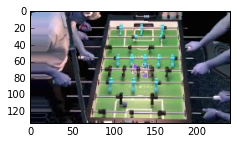

array([[ 0.,  1.,  0.,  0.,  0.,  0.]])


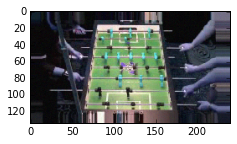

array([[ 0.,  0.,  0.,  1.,  0.,  0.]])


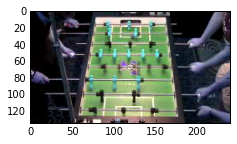

array([[ 0.,  1.,  0.,  0.,  0.,  0.]])


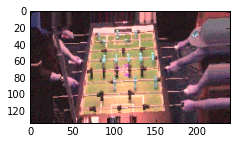

array([[ 0.,  1.,  0.,  0.,  0.,  0.]])


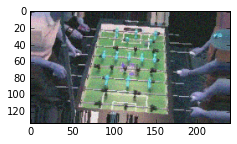

array([[ 0.,  0.,  0.,  0.,  1.,  0.]])


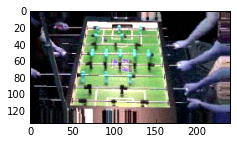

array([[ 0.,  0.,  0.,  1.,  0.,  0.]])


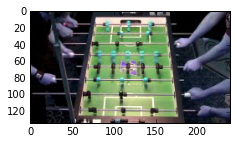

array([[ 0.,  1.,  0.,  0.,  0.,  0.]])


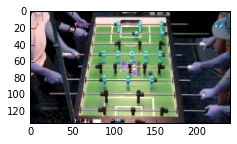

array([[ 0.,  0.,  0.,  0.,  1.,  0.]])


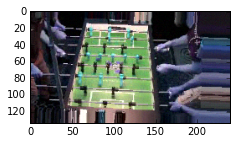

array([[ 0.,  0.,  0.,  0.,  1.,  0.]])


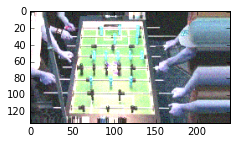

array([[ 0.,  0.,  0.,  0.,  1.,  0.]])


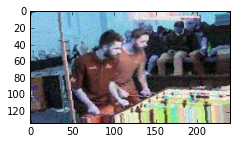

array([[ 1.,  0.,  0.,  0.,  0.,  0.]])


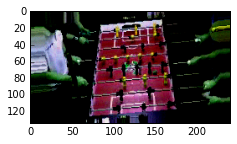

array([[ 0.,  0.,  0.,  0.,  1.,  0.]])


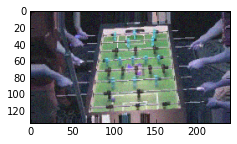

array([[ 0.,  1.,  0.,  0.,  0.,  0.]])


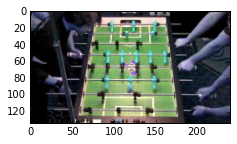

array([[ 0.,  0.,  0.,  1.,  0.,  0.]])


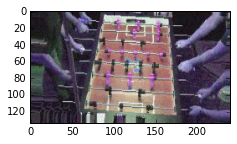

array([[ 0.,  1.,  0.,  0.,  0.,  0.]])


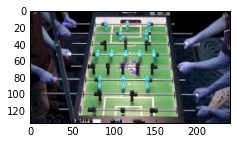

array([[ 0.,  0.,  0.,  0.,  1.,  0.]])


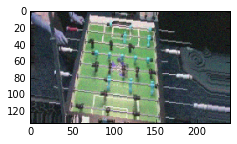

array([[ 1.,  0.,  0.,  0.,  0.,  0.]])


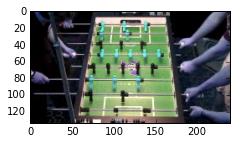

array([[ 0.,  0.,  0.,  1.,  0.,  0.]])


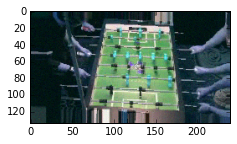

array([[ 1.,  0.,  0.,  0.,  0.,  0.]])


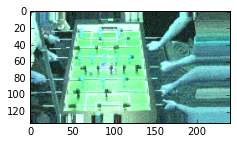

array([[ 0.,  1.,  0.,  0.,  0.,  0.]])


In [12]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# View the first few frames
for k in range(20):
    data = training.get_next_frame()
    frame = data["frame"]
    fig, ax = plt.subplots(figsize=(18, 2))
    plt.imshow(frame)
    plt.show()
    pp.pprint( np.transpose( np.array(data["score_far"] ) ))

In [13]:
# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
class threadsafe_iter(object):
  """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
  def __init__(self, it):
      self.it = it
      self.lock = threading.Lock()

  def __iter__(self):
      return self

  def __next__(self):
      with self.lock:
          return self.it.__next__()

# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
def threadsafe_generator(f):
  """
    A decorator that takes a generator function and makes it thread-safe.
    """
  def g(*a, **kw):
      return threadsafe_iter(f(*a, **kw))
  return g


# Define our training and validation iterators
@threadsafe_generator
def TrainGen(training):
    while True:
        data = training.get_next_frame()
        if data is not None:
            frame = data["frame"]
            output = np.array(data["score_far"])
            if output is None:
                frame = None

            while frame is not None:
                yield (frame, output)
                data = training.get_next_frame()
                if data is not None:
                    frame = data["frame"]
                    output = np.array(data["score_far"])
                    if output is None:
                        frame = None
                else:
                    frame = None
                
             
# Generators for training the position
@threadsafe_generator
def TrainBatchGen(batch_size, training):
    gen = TrainGen(training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, 134, 240, 3), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 6), dtype=np.float32)
        for i in range(batch_size):
            (frame, output) = next(gen)
            batch_frames[i,:,:,:] = frame
            batch_outputs[i,:] = output[:,0]
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")

                
             
# Generators for training the position
@threadsafe_generator
def ValidationBatchGen(batch_size, validation):
    gen = TrainGen(validation)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, 134, 240, 3), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 6), dtype=np.float32)
        for i in range(batch_size):
            (frame, output) = next(gen)
            batch_frames[i,:,:,:] = frame
            batch_outputs[i,:] = output[:,0]
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")
        
    
    
        
    


In [14]:
# Utilities for plotting the result and training
def plot_validate(generator, model, count, name, output_names):   
    outputs_predicted = None
    outputs_true = None
    
    while outputs_predicted is None or outputs_predicted.shape[0] < count:
        
        (new_frames, new_outputs_true) = next(generator)
        if outputs_true is None:
            outputs_true = new_outputs_true
        else:
            outputs_true = np.concatenate( (outputs_true, new_outputs_true), axis=0 )
        
        
        new_outputs_predicted = model.predict(new_frames, batch_size=new_frames.shape[0], verbose=0)
        if outputs_predicted is None:
            outputs_predicted = new_outputs_predicted
        else:
            outputs_predicted = np.concatenate( (outputs_predicted, new_outputs_predicted), axis=0 )
    
    
    f, axes = plt.subplots(outputs_true.shape[1], figsize=(12, 12), sharex=True, sharey=True)
    
    for i in range(outputs_true.shape[1]):
        true, predicted = zip(*sorted(zip(outputs_true[0:count,i], outputs_predicted[0:count,i])))
        axes[i].plot(range(count),true, label="True position" )
        axes[i].plot(range(count),predicted, label="Predicted position" )
        axes[i].grid(False)
        axes[i].set_ylabel(output_names[i])
        if i == 0:
            axes[i].legend()
            axes[i].set_title(name)
            
    
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    
    
    plt.show()

    
    



In [15]:
from keras.models import Sequential
from keras.layers import *
from keras.models import Model



image_height       = 134
image_width        = 240
image_channels     = 3

# Model options
batch_size = 10
lstm_output_size = 300
cnn_kernel_count = 40

# Build the model
pp.pprint("Input shape without batches:")
pp.pprint((image_height, image_width, image_channels))

# Used to give fixed names to the layers for transferring the model
conv_num = 0 
pool_num = 0
dense_num = 0

# Build a functional model design
inputs = Input(shape=(image_height, image_width, image_channels,),
              name="Input")
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "conv2d_%i"%conv_num)(inputs)
conv_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "conv2d_%i"%conv_num)(x)
conv_num+=1

# Split into a horizontal detail and vertical detailed CNN paths
x = MaxPooling2D( pool_size=(1, 2),
                  name = "max_pooling2d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1

x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1


#x = Flatten()(x)
#x = Reshape((number_of_frames,6*6*cnn_kernel_count))(x)
x = Flatten()(x)


x = Dense(128, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
x = Dense(64, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax',name="dense_%i"%dense_num)(x)
dense_num+=1

model = Model(inputs=inputs, outputs=predictions)


# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


model.summary()

# Train the model to predict the future position. This is the control signal to the robot AI
WEIGHTS_FNAME = '.\\Goalie3Frames\\weights_%i.hdf'
MODELS_FNAME = '.\\Goalie3Frames\\models_%i.h5'

'Input shape without batches:'
(134, 240, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 134, 240, 3)       0         
_________________________________________________________________
conv2d_0 (Conv2D)            (None, 134, 240, 40)      1120      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 134, 240, 40)      14440     
_________________________________________________________________
max_pooling2d_0 (MaxPooling2 (None, 134, 120, 40)      0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 134, 120, 40)      14440     
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 134, 120, 40)      14440     
_________________________________________________________________
max_pooling3d_1 (MaxPooling2 (N

Batch size 20: 161 training batches, 40 validation batches
Epoch 1/1
161/161 [==============================] - 62s - loss: 1.7104 - categorical_accuracy: 0.3022 - val_loss: 1.5747 - val_categorical_accuracy: 0.2863


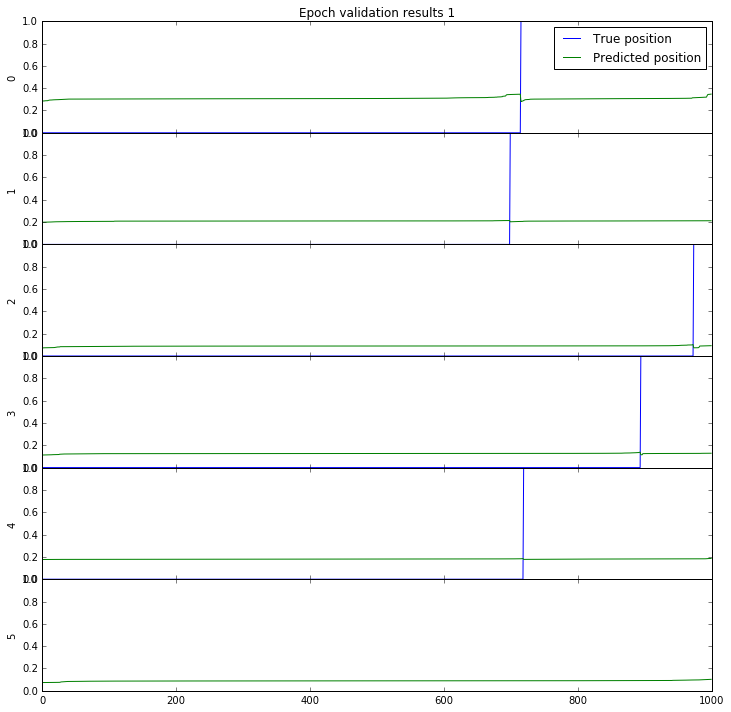

Wrote model to .\Models\models_1.h5
Epoch 2/2
161/161 [==============================] - 68s - loss: 1.5912 - categorical_accuracy: 0.3102 - val_loss: 1.5177 - val_categorical_accuracy: 0.2875
Wrote model to .\Models\models_2.h5
Epoch 3/3
161/161 [==============================] - 72s - loss: 1.5823 - categorical_accuracy: 0.3075 - val_loss: 1.5032 - val_categorical_accuracy: 0.2850
Wrote model to .\Models\models_3.h5
Epoch 4/4
161/161 [==============================] - 74s - loss: 1.5705 - categorical_accuracy: 0.3003 - val_loss: 1.4873 - val_categorical_accuracy: 0.2863
Wrote model to .\Models\models_4.h5
Epoch 5/5
161/161 [==============================] - 66s - loss: 1.5489 - categorical_accuracy: 0.3019 - val_loss: 1.4652 - val_categorical_accuracy: 0.2875
Wrote model to .\Models\models_5.h5
Epoch 6/6
161/161 [==============================] - 54s - loss: 1.5474 - categorical_accuracy: 0.3006 - val_loss: 1.4689 - val_categorical_accuracy: 0.2863
Wrote model to .\Models\models_6.h5

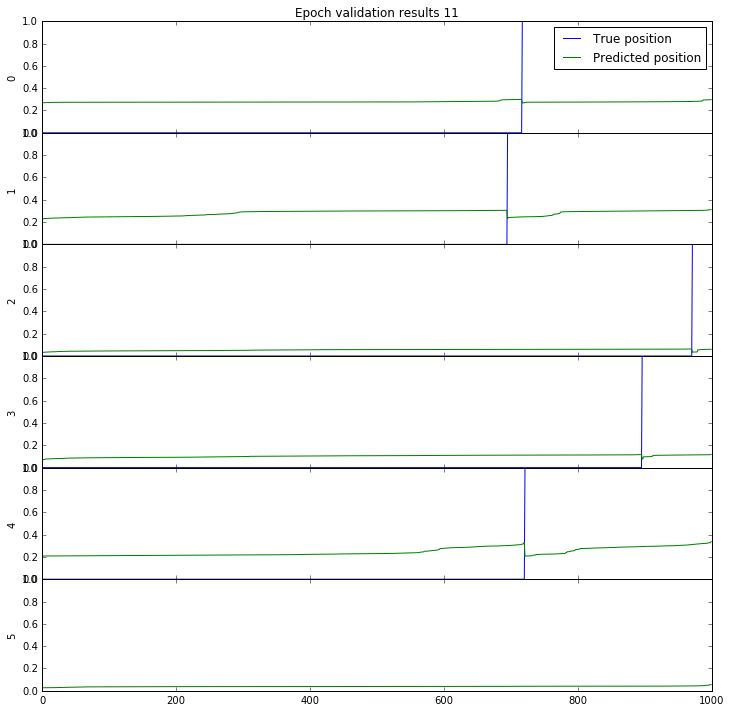

Wrote model to .\Models\models_11.h5
Epoch 12/12
161/161 [==============================] - 53s - loss: 1.4779 - categorical_accuracy: 0.3438 - val_loss: 1.3654 - val_categorical_accuracy: 0.4350
Wrote model to .\Models\models_12.h5
Epoch 13/13
161/161 [==============================] - 54s - loss: 1.4516 - categorical_accuracy: 0.3671 - val_loss: 1.3473 - val_categorical_accuracy: 0.4313
Wrote model to .\Models\models_13.h5
Epoch 14/14
161/161 [==============================] - 53s - loss: 1.4510 - categorical_accuracy: 0.3764 - val_loss: 1.3183 - val_categorical_accuracy: 0.4363
Wrote model to .\Models\models_14.h5
Epoch 15/15
161/161 [==============================] - 60s - loss: 1.4262 - categorical_accuracy: 0.4025 - val_loss: 1.3307 - val_categorical_accuracy: 0.4150
Wrote model to .\Models\models_15.h5
Epoch 16/16
161/161 [==============================] - 54s - loss: 1.4042 - categorical_accuracy: 0.4012 - val_loss: 1.2983 - val_categorical_accuracy: 0.4700
Wrote model to .\Mod

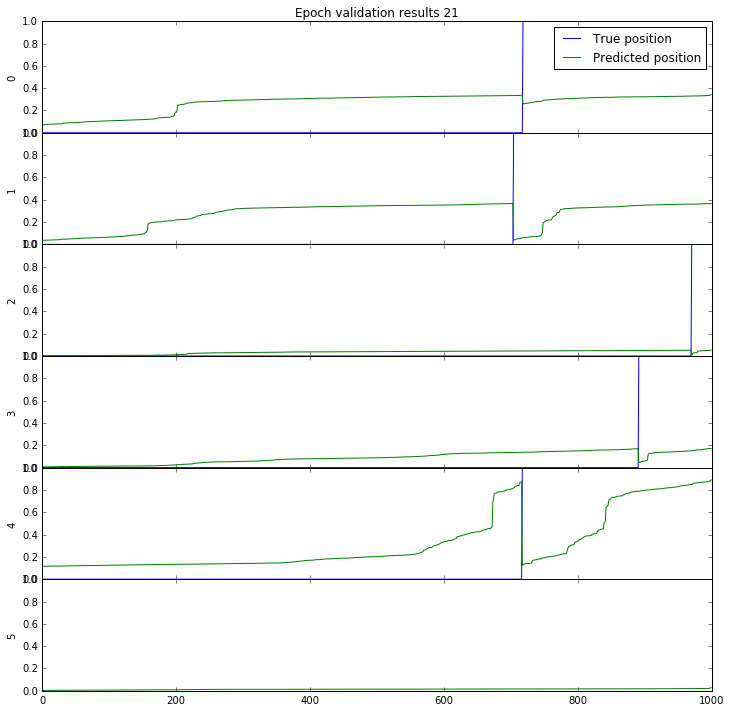

Wrote model to .\Models\models_21.h5
Epoch 22/22
161/161 [==============================] - 54s - loss: 1.3529 - categorical_accuracy: 0.4174 - val_loss: 1.2300 - val_categorical_accuracy: 0.4988
Wrote model to .\Models\models_22.h5
Epoch 23/23
161/161 [==============================] - 53s - loss: 1.3360 - categorical_accuracy: 0.4224 - val_loss: 1.2382 - val_categorical_accuracy: 0.4763
Wrote model to .\Models\models_23.h5
Epoch 24/24
161/161 [==============================] - 53s - loss: 1.3323 - categorical_accuracy: 0.4317 - val_loss: 1.2378 - val_categorical_accuracy: 0.5013
Wrote model to .\Models\models_24.h5
Epoch 25/25
161/161 [==============================] - 54s - loss: 1.3432 - categorical_accuracy: 0.4202 - val_loss: 1.2356 - val_categorical_accuracy: 0.5113
Wrote model to .\Models\models_25.h5
Epoch 26/26
161/161 [==============================] - 53s - loss: 1.3229 - categorical_accuracy: 0.4463 - val_loss: 1.2245 - val_categorical_accuracy: 0.4913
Wrote model to .\Mod

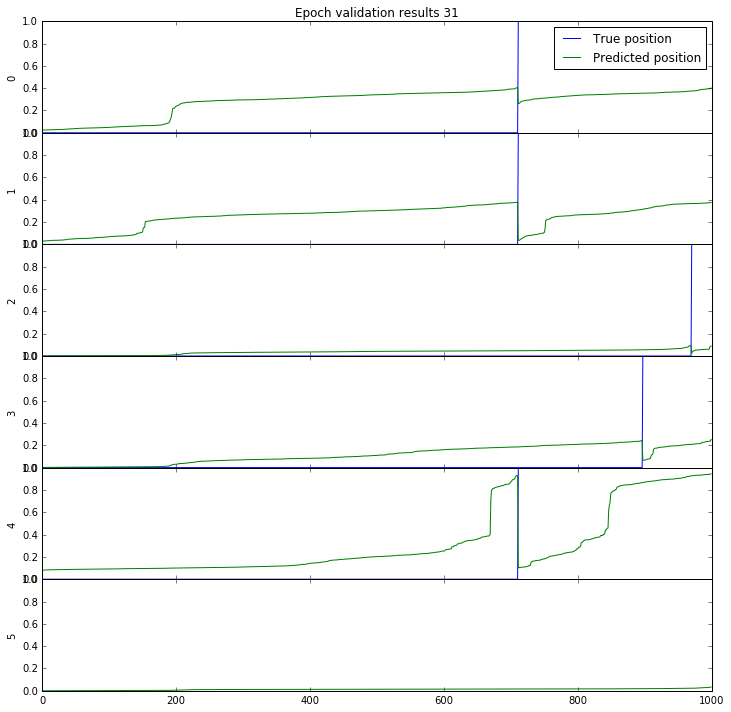

Wrote model to .\Models\models_31.h5
Epoch 32/32
161/161 [==============================] - 54s - loss: 1.2813 - categorical_accuracy: 0.4516 - val_loss: 1.1921 - val_categorical_accuracy: 0.5163
Wrote model to .\Models\models_32.h5
Epoch 33/33
161/161 [==============================] - 53s - loss: 1.2866 - categorical_accuracy: 0.4506 - val_loss: 1.1778 - val_categorical_accuracy: 0.5238
Wrote model to .\Models\models_33.h5
Epoch 34/34
161/161 [==============================] - 53s - loss: 1.2927 - categorical_accuracy: 0.4410 - val_loss: 1.1739 - val_categorical_accuracy: 0.5300
Wrote model to .\Models\models_34.h5
Epoch 35/35
161/161 [==============================] - 54s - loss: 1.2720 - categorical_accuracy: 0.4575 - val_loss: 1.1619 - val_categorical_accuracy: 0.5275
Wrote model to .\Models\models_35.h5
Epoch 36/36
161/161 [==============================] - 54s - loss: 1.2668 - categorical_accuracy: 0.4565 - val_loss: 1.1552 - val_categorical_accuracy: 0.5288
Wrote model to .\Mod

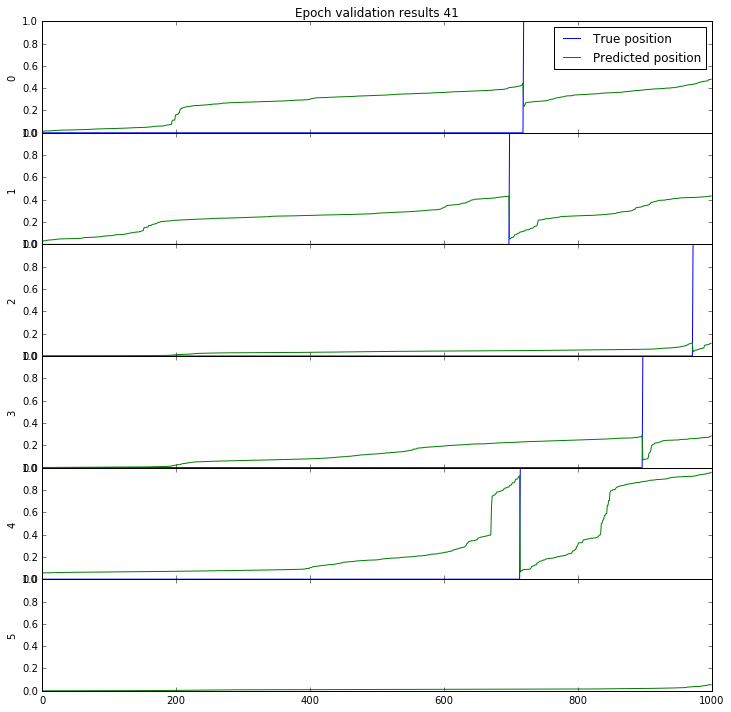

Wrote model to .\Models\models_41.h5
Epoch 42/42
161/161 [==============================] - 54s - loss: 1.2576 - categorical_accuracy: 0.4677 - val_loss: 1.1199 - val_categorical_accuracy: 0.5350
Wrote model to .\Models\models_42.h5
Epoch 43/43
161/161 [==============================] - 53s - loss: 1.2359 - categorical_accuracy: 0.4503 - val_loss: 1.1148 - val_categorical_accuracy: 0.5250
Wrote model to .\Models\models_43.h5
Epoch 44/44
161/161 [==============================] - 54s - loss: 1.2412 - categorical_accuracy: 0.4720 - val_loss: 1.1016 - val_categorical_accuracy: 0.5288
Wrote model to .\Models\models_44.h5
Epoch 45/45
161/161 [==============================] - 54s - loss: 1.2358 - categorical_accuracy: 0.4699 - val_loss: 1.1001 - val_categorical_accuracy: 0.5350
Wrote model to .\Models\models_45.h5
Epoch 46/46
161/161 [==============================] - 53s - loss: 1.2213 - categorical_accuracy: 0.4804 - val_loss: 1.0806 - val_categorical_accuracy: 0.5388
Wrote model to .\Mod

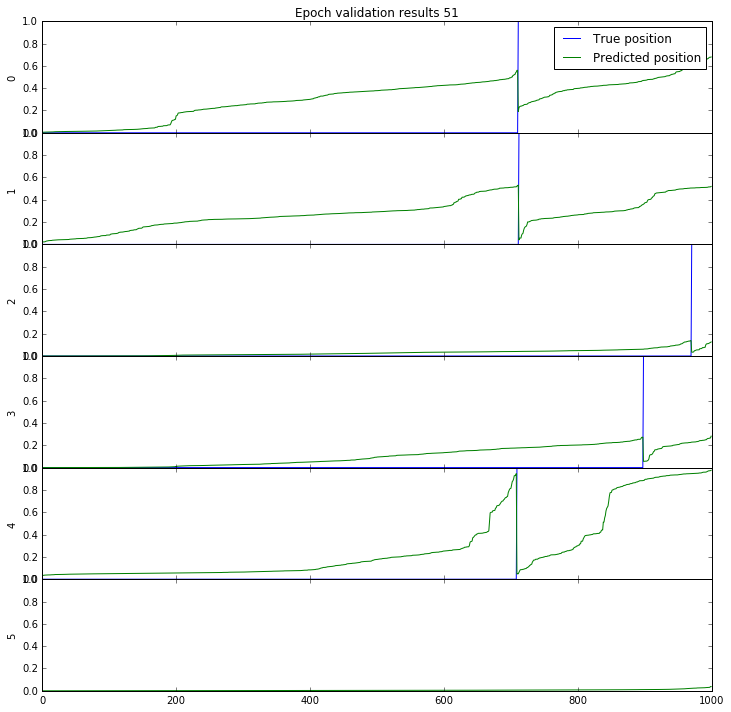

Wrote model to .\Models\models_51.h5
Epoch 52/52
161/161 [==============================] - 54s - loss: 1.1963 - categorical_accuracy: 0.4854 - val_loss: 1.0583 - val_categorical_accuracy: 0.5450
Wrote model to .\Models\models_52.h5
Epoch 53/53
161/161 [==============================] - 53s - loss: 1.1873 - categorical_accuracy: 0.4913 - val_loss: 1.0302 - val_categorical_accuracy: 0.5438
Wrote model to .\Models\models_53.h5
Epoch 54/54
161/161 [==============================] - 53s - loss: 1.1930 - categorical_accuracy: 0.4807 - val_loss: 1.0391 - val_categorical_accuracy: 0.5375
Wrote model to .\Models\models_54.h5
Epoch 55/55
161/161 [==============================] - 54s - loss: 1.1839 - categorical_accuracy: 0.4941 - val_loss: 1.0305 - val_categorical_accuracy: 0.5488
Wrote model to .\Models\models_55.h5
Epoch 56/56
161/161 [==============================] - 53s - loss: 1.1693 - categorical_accuracy: 0.5028 - val_loss: 1.0251 - val_categorical_accuracy: 0.5363
Wrote model to .\Mod

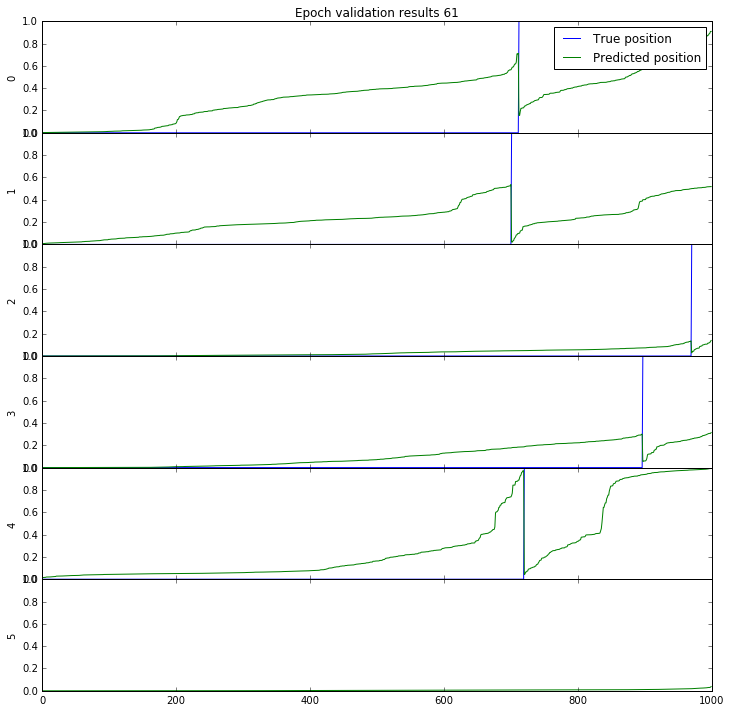

Wrote model to .\Models\models_61.h5
Epoch 62/62
161/161 [==============================] - 52s - loss: 1.1475 - categorical_accuracy: 0.5068 - val_loss: 0.9748 - val_categorical_accuracy: 0.5513
Wrote model to .\Models\models_62.h5
Epoch 63/63
161/161 [==============================] - 53s - loss: 1.1443 - categorical_accuracy: 0.5003 - val_loss: 0.9934 - val_categorical_accuracy: 0.5563
Wrote model to .\Models\models_63.h5
Epoch 64/64
161/161 [==============================] - 53s - loss: 1.1517 - categorical_accuracy: 0.5003 - val_loss: 0.9893 - val_categorical_accuracy: 0.5588
Wrote model to .\Models\models_64.h5
Epoch 65/65
161/161 [==============================] - 53s - loss: 1.1486 - categorical_accuracy: 0.5040 - val_loss: 0.9813 - val_categorical_accuracy: 0.5625
Wrote model to .\Models\models_65.h5
Epoch 66/66
161/161 [==============================] - 53s - loss: 1.1396 - categorical_accuracy: 0.5127 - val_loss: 0.9756 - val_categorical_accuracy: 0.5513
Wrote model to .\Mod

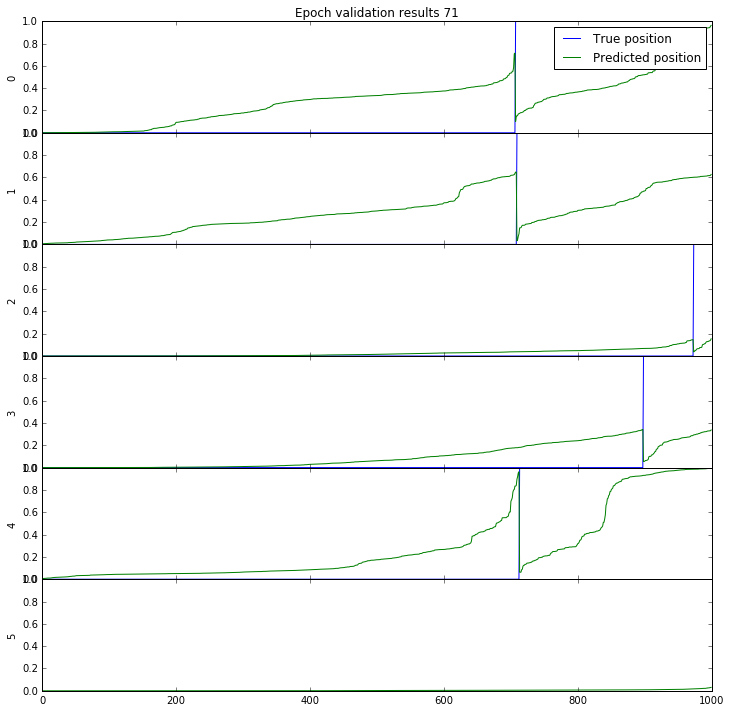

Wrote model to .\Models\models_71.h5
Epoch 72/72
161/161 [==============================] - 53s - loss: 1.1089 - categorical_accuracy: 0.5239 - val_loss: 0.9466 - val_categorical_accuracy: 0.5975
Wrote model to .\Models\models_72.h5
Epoch 73/73
161/161 [==============================] - 53s - loss: 1.0983 - categorical_accuracy: 0.5289 - val_loss: 0.9352 - val_categorical_accuracy: 0.5788
Wrote model to .\Models\models_73.h5
Epoch 74/74
161/161 [==============================] - 53s - loss: 1.0916 - categorical_accuracy: 0.5255 - val_loss: 0.9364 - val_categorical_accuracy: 0.5625
Wrote model to .\Models\models_74.h5
Epoch 75/75
161/161 [==============================] - 53s - loss: 1.1062 - categorical_accuracy: 0.5239 - val_loss: 0.9289 - val_categorical_accuracy: 0.5650
Wrote model to .\Models\models_75.h5
Epoch 76/76
161/161 [==============================] - 53s - loss: 1.0981 - categorical_accuracy: 0.5239 - val_loss: 0.9249 - val_categorical_accuracy: 0.5763
Wrote model to .\Mod

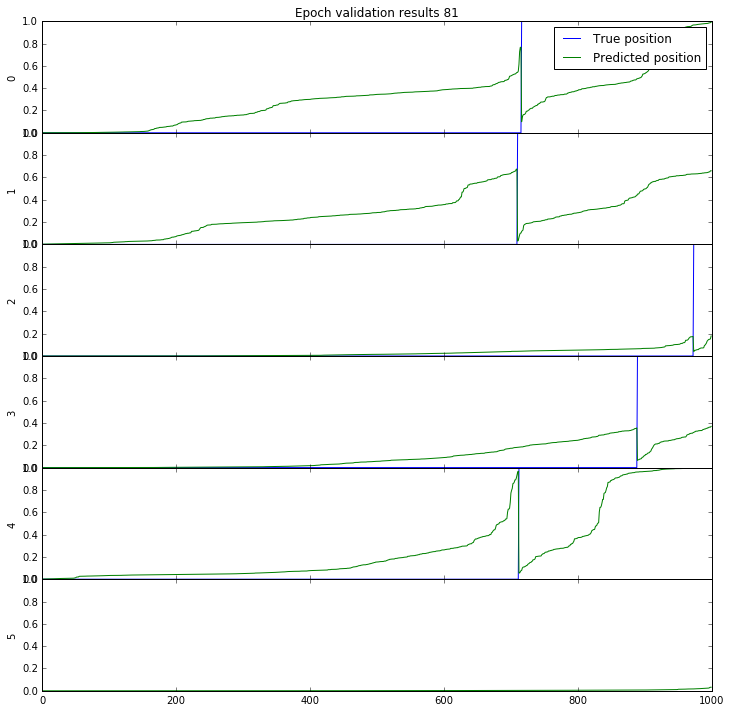

Wrote model to .\Models\models_81.h5
Epoch 82/82
161/161 [==============================] - 53s - loss: 1.0715 - categorical_accuracy: 0.5317 - val_loss: 0.9162 - val_categorical_accuracy: 0.5638
Wrote model to .\Models\models_82.h5
Epoch 83/83
161/161 [==============================] - 53s - loss: 1.0789 - categorical_accuracy: 0.5335 - val_loss: 0.9070 - val_categorical_accuracy: 0.5825
Wrote model to .\Models\models_83.h5
Epoch 84/84
161/161 [==============================] - 53s - loss: 1.0919 - categorical_accuracy: 0.5261 - val_loss: 0.9210 - val_categorical_accuracy: 0.5863
Wrote model to .\Models\models_84.h5
Epoch 85/85
161/161 [==============================] - 53s - loss: 1.0640 - categorical_accuracy: 0.5472 - val_loss: 0.9029 - val_categorical_accuracy: 0.6088
Wrote model to .\Models\models_85.h5
Epoch 86/86
161/161 [==============================] - 53s - loss: 1.0777 - categorical_accuracy: 0.5345 - val_loss: 0.9054 - val_categorical_accuracy: 0.5838
Wrote model to .\Mod

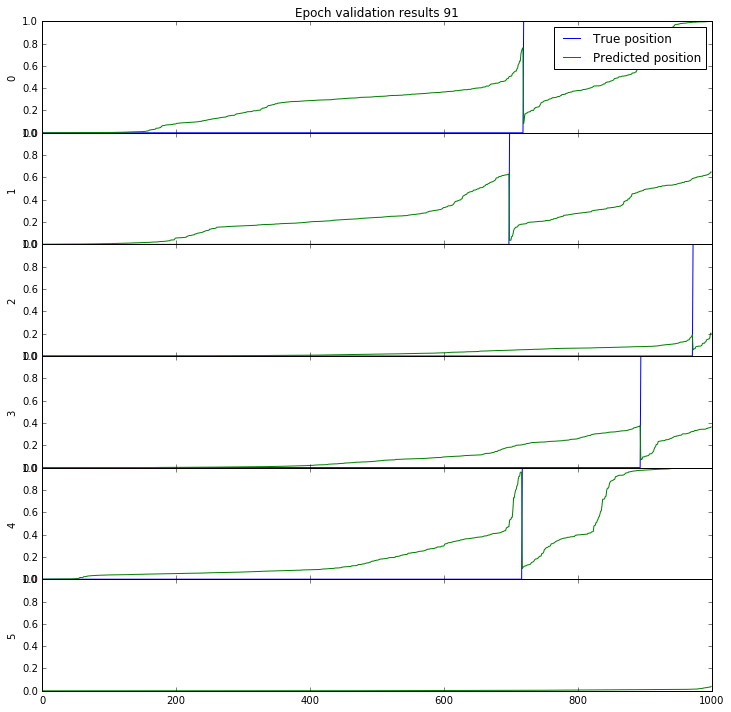

Wrote model to .\Models\models_91.h5
Epoch 92/92
161/161 [==============================] - 53s - loss: 1.0582 - categorical_accuracy: 0.5345 - val_loss: 0.8798 - val_categorical_accuracy: 0.6125
Wrote model to .\Models\models_92.h5
Epoch 93/93
161/161 [==============================] - 53s - loss: 1.0612 - categorical_accuracy: 0.5425 - val_loss: 0.8925 - val_categorical_accuracy: 0.5788
Wrote model to .\Models\models_93.h5
Epoch 94/94
161/161 [==============================] - 53s - loss: 1.0405 - categorical_accuracy: 0.5494 - val_loss: 0.8626 - val_categorical_accuracy: 0.6325
Wrote model to .\Models\models_94.h5
Epoch 95/95
161/161 [==============================] - 53s - loss: 1.0459 - categorical_accuracy: 0.5453 - val_loss: 0.8766 - val_categorical_accuracy: 0.6263
Wrote model to .\Models\models_95.h5
Epoch 96/96
161/161 [==============================] - 53s - loss: 1.0414 - categorical_accuracy: 0.5512 - val_loss: 0.8760 - val_categorical_accuracy: 0.6225
Wrote model to .\Mod

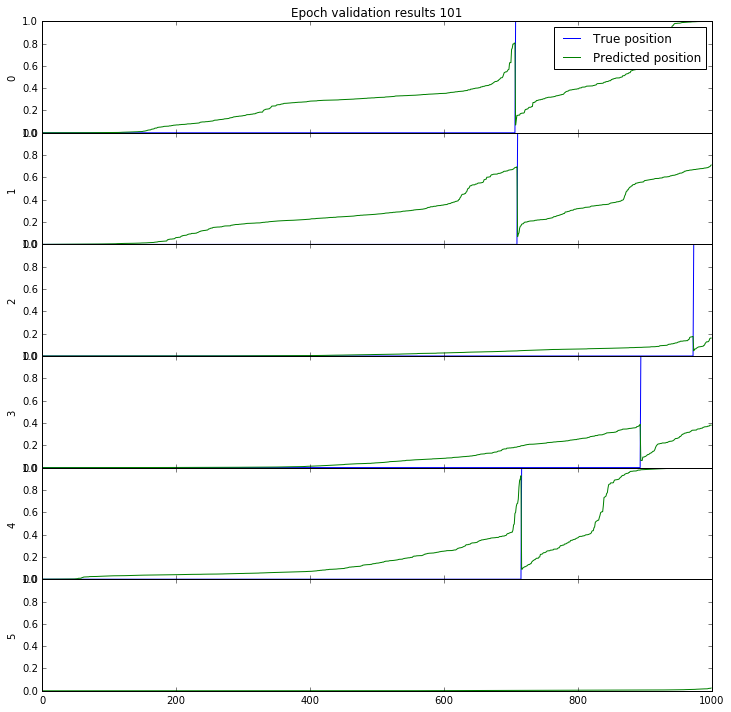

Wrote model to .\Models\models_101.h5
Epoch 102/102
161/161 [==============================] - 52s - loss: 1.0232 - categorical_accuracy: 0.5609 - val_loss: 0.8546 - val_categorical_accuracy: 0.6363
Wrote model to .\Models\models_102.h5
Epoch 103/103
161/161 [==============================] - 53s - loss: 1.0203 - categorical_accuracy: 0.5522 - val_loss: 0.8513 - val_categorical_accuracy: 0.6463
Wrote model to .\Models\models_103.h5
Epoch 104/104
161/161 [==============================] - 53s - loss: 1.0223 - categorical_accuracy: 0.5553 - val_loss: 0.8633 - val_categorical_accuracy: 0.6500
Wrote model to .\Models\models_104.h5
Epoch 105/105
161/161 [==============================] - 53s - loss: 1.0088 - categorical_accuracy: 0.5640 - val_loss: 0.8495 - val_categorical_accuracy: 0.6625
Wrote model to .\Models\models_105.h5
Epoch 106/106
161/161 [==============================] - 52s - loss: 1.0170 - categorical_accuracy: 0.5562 - val_loss: 0.8588 - val_categorical_accuracy: 0.6263
Wrote

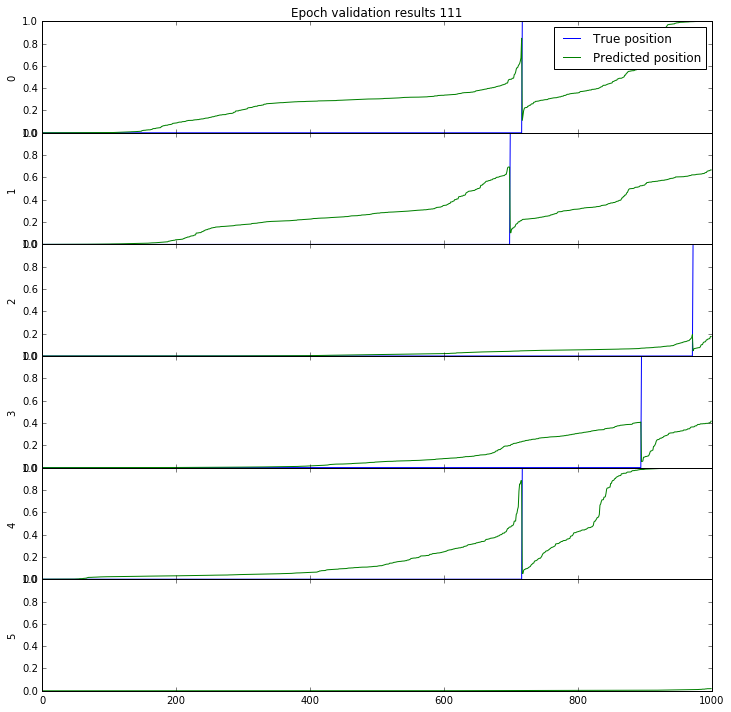

Wrote model to .\Models\models_111.h5
Epoch 112/112
161/161 [==============================] - 53s - loss: 1.0038 - categorical_accuracy: 0.5615 - val_loss: 0.8276 - val_categorical_accuracy: 0.6575
Wrote model to .\Models\models_112.h5
Epoch 113/113
161/161 [==============================] - 53s - loss: 1.0029 - categorical_accuracy: 0.5640 - val_loss: 0.8186 - val_categorical_accuracy: 0.6500
Wrote model to .\Models\models_113.h5
Epoch 114/114
161/161 [==============================] - 53s - loss: 0.9925 - categorical_accuracy: 0.5596 - val_loss: 0.8259 - val_categorical_accuracy: 0.6500
Wrote model to .\Models\models_114.h5
Epoch 115/115
161/161 [==============================] - 53s - loss: 0.9966 - categorical_accuracy: 0.5658 - val_loss: 0.8227 - val_categorical_accuracy: 0.6613
Wrote model to .\Models\models_115.h5
Epoch 116/116
161/161 [==============================] - 53s - loss: 0.9957 - categorical_accuracy: 0.5618 - val_loss: 0.8159 - val_categorical_accuracy: 0.6625
Wrote

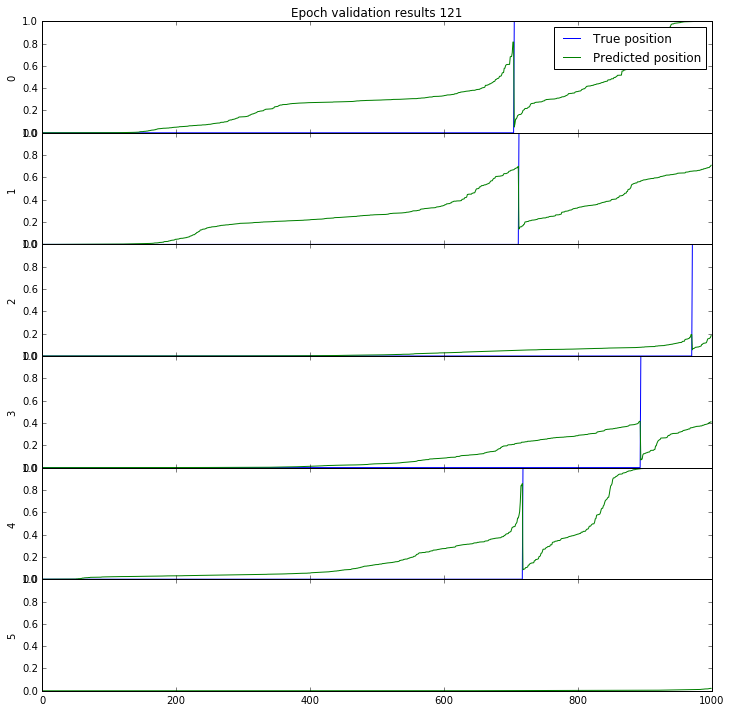

Wrote model to .\Models\models_121.h5
Epoch 122/122
161/161 [==============================] - 54s - loss: 0.9796 - categorical_accuracy: 0.5727 - val_loss: 0.8175 - val_categorical_accuracy: 0.6638
Wrote model to .\Models\models_122.h5
Epoch 123/123
161/161 [==============================] - 53s - loss: 0.9614 - categorical_accuracy: 0.5811 - val_loss: 0.8019 - val_categorical_accuracy: 0.6825
Wrote model to .\Models\models_123.h5
Epoch 124/124
161/161 [==============================] - 53s - loss: 0.9731 - categorical_accuracy: 0.5730 - val_loss: 0.7886 - val_categorical_accuracy: 0.6638
Wrote model to .\Models\models_124.h5
Epoch 125/125
161/161 [==============================] - 53s - loss: 0.9799 - categorical_accuracy: 0.5730 - val_loss: 0.7888 - val_categorical_accuracy: 0.6613
Wrote model to .\Models\models_125.h5
Epoch 126/126
161/161 [==============================] - 52s - loss: 0.9668 - categorical_accuracy: 0.5699 - val_loss: 0.7755 - val_categorical_accuracy: 0.6975
Wrote

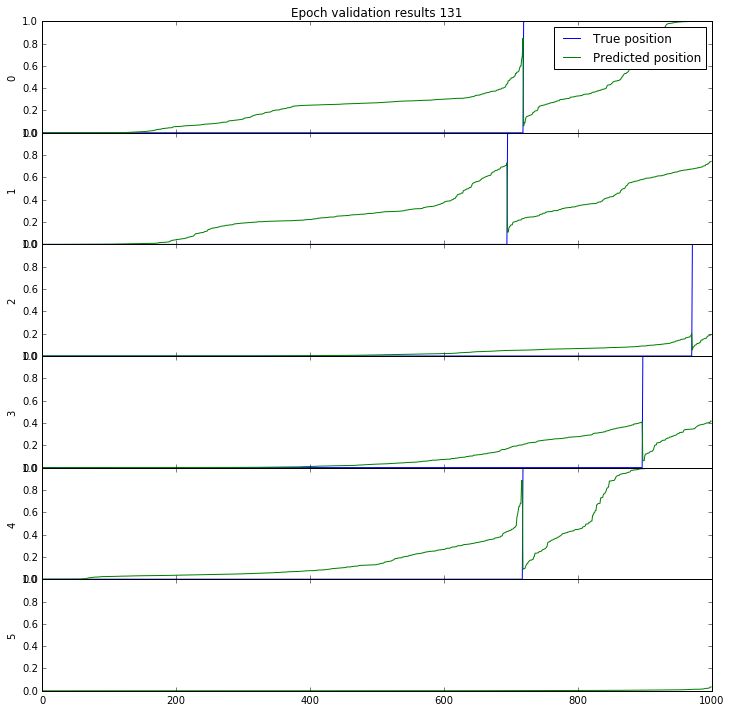

Wrote model to .\Models\models_131.h5
Epoch 132/132
161/161 [==============================] - 53s - loss: 0.9621 - categorical_accuracy: 0.5845 - val_loss: 0.7778 - val_categorical_accuracy: 0.6950
Wrote model to .\Models\models_132.h5
Epoch 133/133
161/161 [==============================] - 53s - loss: 0.9696 - categorical_accuracy: 0.5727 - val_loss: 0.7763 - val_categorical_accuracy: 0.6913
Wrote model to .\Models\models_133.h5
Epoch 134/134
161/161 [==============================] - 53s - loss: 0.9486 - categorical_accuracy: 0.5910 - val_loss: 0.7764 - val_categorical_accuracy: 0.6800
Wrote model to .\Models\models_134.h5
Epoch 135/135
161/161 [==============================] - 53s - loss: 0.9423 - categorical_accuracy: 0.5935 - val_loss: 0.7615 - val_categorical_accuracy: 0.6850
Wrote model to .\Models\models_135.h5
Epoch 136/136
161/161 [==============================] - 53s - loss: 0.9542 - categorical_accuracy: 0.5789 - val_loss: 0.7756 - val_categorical_accuracy: 0.6775
Wrote

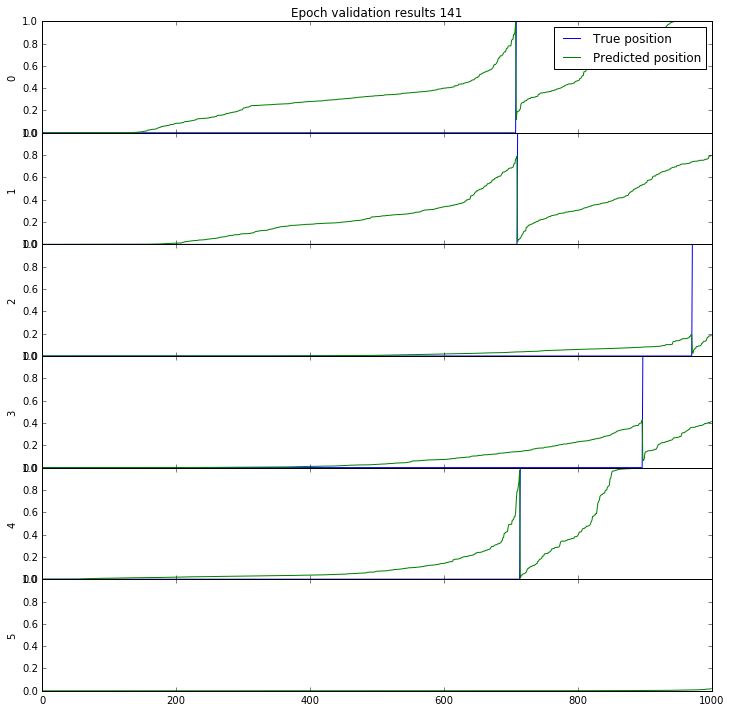

Wrote model to .\Models\models_141.h5
Epoch 142/142
161/161 [==============================] - 53s - loss: 0.9440 - categorical_accuracy: 0.5854 - val_loss: 0.7414 - val_categorical_accuracy: 0.6888
Wrote model to .\Models\models_142.h5
Epoch 143/143
161/161 [==============================] - 53s - loss: 0.9393 - categorical_accuracy: 0.5888 - val_loss: 0.7483 - val_categorical_accuracy: 0.6900
Wrote model to .\Models\models_143.h5
Epoch 144/144
161/161 [==============================] - 53s - loss: 0.9373 - categorical_accuracy: 0.5904 - val_loss: 0.7746 - val_categorical_accuracy: 0.6913
Wrote model to .\Models\models_144.h5
Epoch 145/145
161/161 [==============================] - 53s - loss: 0.9237 - categorical_accuracy: 0.5963 - val_loss: 0.7398 - val_categorical_accuracy: 0.6900
Wrote model to .\Models\models_145.h5
Epoch 146/146
161/161 [==============================] - 53s - loss: 0.9294 - categorical_accuracy: 0.5922 - val_loss: 0.7383 - val_categorical_accuracy: 0.6975
Wrote

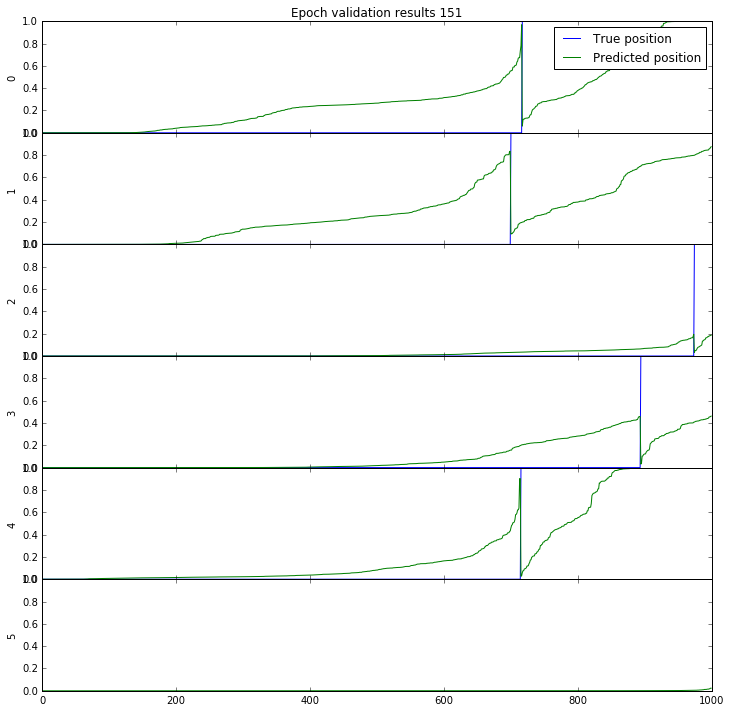

Wrote model to .\Models\models_151.h5
Epoch 152/152
161/161 [==============================] - 53s - loss: 0.9155 - categorical_accuracy: 0.5941 - val_loss: 0.7201 - val_categorical_accuracy: 0.7088
Wrote model to .\Models\models_152.h5
Epoch 153/153
161/161 [==============================] - 54s - loss: 0.9274 - categorical_accuracy: 0.5947 - val_loss: 0.7113 - val_categorical_accuracy: 0.7100
Wrote model to .\Models\models_153.h5
Epoch 154/154
161/161 [==============================] - 52s - loss: 0.9062 - categorical_accuracy: 0.6022 - val_loss: 0.6976 - val_categorical_accuracy: 0.7263
Wrote model to .\Models\models_154.h5
Epoch 155/155
161/161 [==============================] - 53s - loss: 0.9231 - categorical_accuracy: 0.5960 - val_loss: 0.7033 - val_categorical_accuracy: 0.7113
Wrote model to .\Models\models_155.h5
Epoch 156/156
161/161 [==============================] - 53s - loss: 0.8947 - categorical_accuracy: 0.6078 - val_loss: 0.6904 - val_categorical_accuracy: 0.7050
Wrote

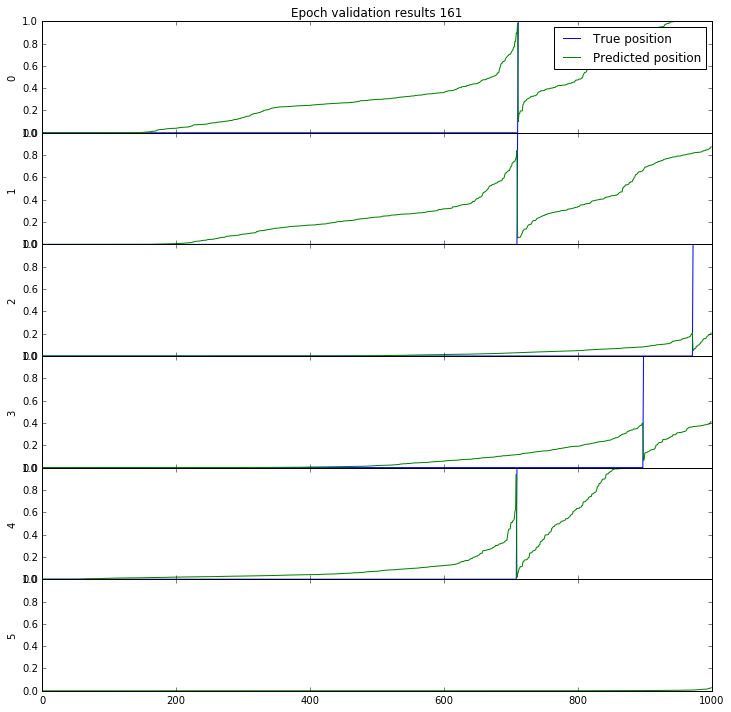

Wrote model to .\Models\models_161.h5
Epoch 162/162
161/161 [==============================] - 53s - loss: 0.8970 - categorical_accuracy: 0.6006 - val_loss: 0.6558 - val_categorical_accuracy: 0.7513
Wrote model to .\Models\models_162.h5
Epoch 163/163
161/161 [==============================] - 53s - loss: 0.8817 - categorical_accuracy: 0.6130 - val_loss: 0.6543 - val_categorical_accuracy: 0.7438
Wrote model to .\Models\models_163.h5
Epoch 164/164
161/161 [==============================] - 53s - loss: 0.8799 - categorical_accuracy: 0.6242 - val_loss: 0.6244 - val_categorical_accuracy: 0.7600
Wrote model to .\Models\models_164.h5
Epoch 165/165
161/161 [==============================] - 52s - loss: 0.8724 - categorical_accuracy: 0.6255 - val_loss: 0.6333 - val_categorical_accuracy: 0.7663
Wrote model to .\Models\models_165.h5
Epoch 166/166
161/161 [==============================] - 52s - loss: 0.8587 - categorical_accuracy: 0.6196 - val_loss: 0.6122 - val_categorical_accuracy: 0.7538
Wrote

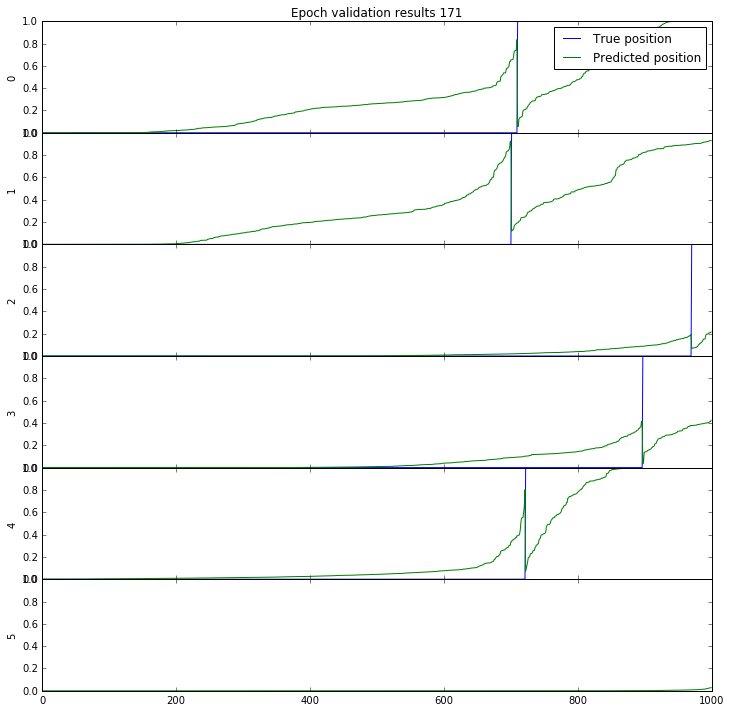

Wrote model to .\Models\models_171.h5
Epoch 172/172
161/161 [==============================] - 53s - loss: 0.8464 - categorical_accuracy: 0.6357 - val_loss: 0.5633 - val_categorical_accuracy: 0.7738
Wrote model to .\Models\models_172.h5
Epoch 173/173
161/161 [==============================] - 53s - loss: 0.8394 - categorical_accuracy: 0.6382 - val_loss: 0.5604 - val_categorical_accuracy: 0.7925
Wrote model to .\Models\models_173.h5
Epoch 174/174
161/161 [==============================] - 53s - loss: 0.8320 - categorical_accuracy: 0.6332 - val_loss: 0.5419 - val_categorical_accuracy: 0.8025
Wrote model to .\Models\models_174.h5
Epoch 175/175
161/161 [==============================] - 53s - loss: 0.8192 - categorical_accuracy: 0.6494 - val_loss: 0.5603 - val_categorical_accuracy: 0.7788
Wrote model to .\Models\models_175.h5
Epoch 176/176
161/161 [==============================] - 53s - loss: 0.8264 - categorical_accuracy: 0.6363 - val_loss: 0.5619 - val_categorical_accuracy: 0.8050
Wrote

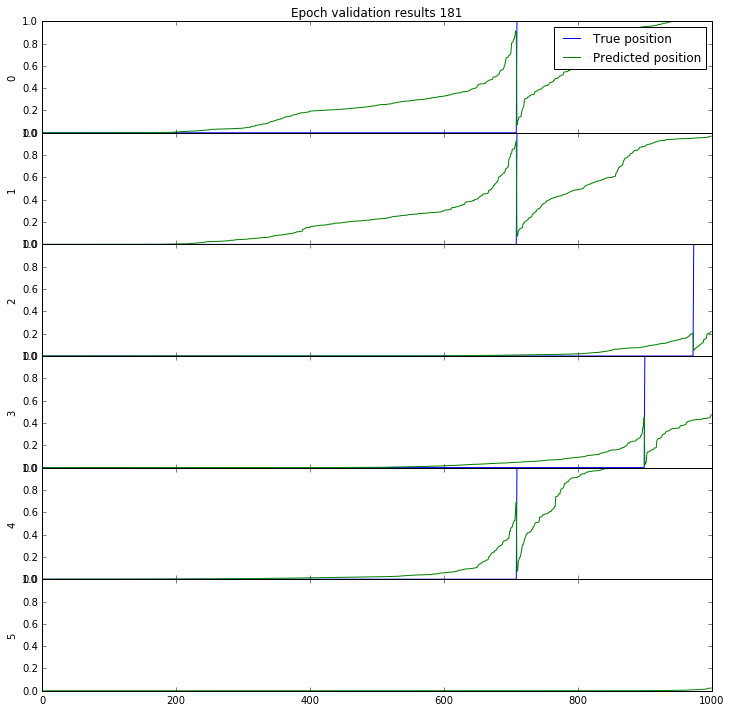

Wrote model to .\Models\models_181.h5
Epoch 182/182
161/161 [==============================] - 52s - loss: 0.7721 - categorical_accuracy: 0.6761 - val_loss: 0.4956 - val_categorical_accuracy: 0.8238
Wrote model to .\Models\models_182.h5
Epoch 183/183
161/161 [==============================] - 53s - loss: 0.7773 - categorical_accuracy: 0.6689 - val_loss: 0.4881 - val_categorical_accuracy: 0.8300
Wrote model to .\Models\models_183.h5
Epoch 184/184
161/161 [==============================] - 54s - loss: 0.7711 - categorical_accuracy: 0.6727 - val_loss: 0.4876 - val_categorical_accuracy: 0.8475
Wrote model to .\Models\models_184.h5
Epoch 185/185
161/161 [==============================] - 53s - loss: 0.7444 - categorical_accuracy: 0.6854 - val_loss: 0.4682 - val_categorical_accuracy: 0.8388
Wrote model to .\Models\models_185.h5
Epoch 186/186
161/161 [==============================] - 53s - loss: 0.7378 - categorical_accuracy: 0.6885 - val_loss: 0.4555 - val_categorical_accuracy: 0.8613
Wrote

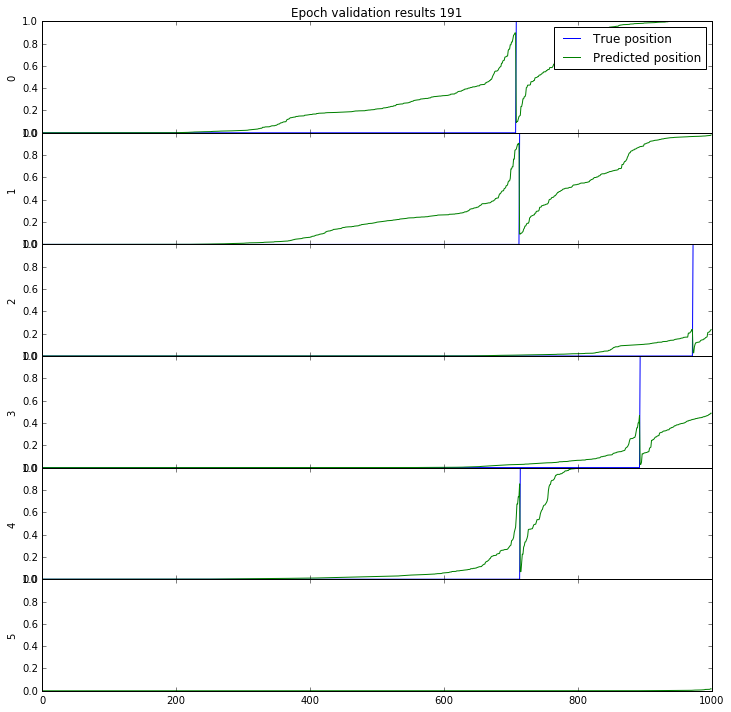

Wrote model to .\Models\models_191.h5
Epoch 192/192
161/161 [==============================] - 53s - loss: 0.6917 - categorical_accuracy: 0.7121 - val_loss: 0.4410 - val_categorical_accuracy: 0.8675
Wrote model to .\Models\models_192.h5
Epoch 193/193
161/161 [==============================] - 53s - loss: 0.6932 - categorical_accuracy: 0.7286 - val_loss: 0.3997 - val_categorical_accuracy: 0.8837
Wrote model to .\Models\models_193.h5
Epoch 194/194
161/161 [==============================] - 53s - loss: 0.6839 - categorical_accuracy: 0.7193 - val_loss: 0.3718 - val_categorical_accuracy: 0.8937
Wrote model to .\Models\models_194.h5
Epoch 195/195
161/161 [==============================] - 52s - loss: 0.6789 - categorical_accuracy: 0.7196 - val_loss: 0.3771 - val_categorical_accuracy: 0.8900
Wrote model to .\Models\models_195.h5
Epoch 196/196
161/161 [==============================] - 52s - loss: 0.6605 - categorical_accuracy: 0.7289 - val_loss: 0.3567 - val_categorical_accuracy: 0.8925
Wrote

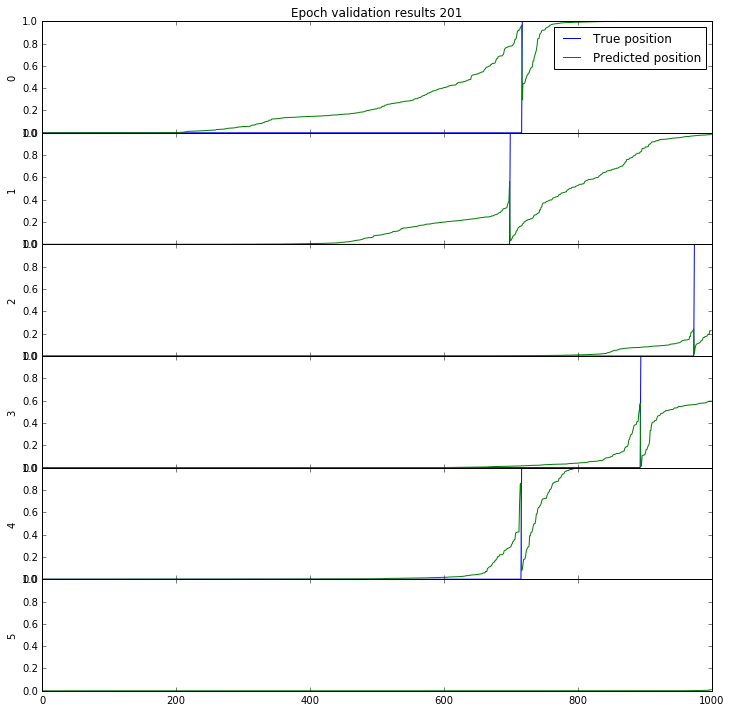

Wrote model to .\Models\models_201.h5
Epoch 202/202
161/161 [==============================] - 53s - loss: 0.6250 - categorical_accuracy: 0.7522 - val_loss: 0.3382 - val_categorical_accuracy: 0.8887
Wrote model to .\Models\models_202.h5
Epoch 203/203
161/161 [==============================] - 54s - loss: 0.6154 - categorical_accuracy: 0.7571 - val_loss: 0.3152 - val_categorical_accuracy: 0.8975
Wrote model to .\Models\models_203.h5
Epoch 204/204
161/161 [==============================] - 53s - loss: 0.6094 - categorical_accuracy: 0.7640 - val_loss: 0.3426 - val_categorical_accuracy: 0.8788
Wrote model to .\Models\models_204.h5
Epoch 205/205
161/161 [==============================] - 53s - loss: 0.6200 - categorical_accuracy: 0.7612 - val_loss: 0.2970 - val_categorical_accuracy: 0.9237
Wrote model to .\Models\models_205.h5
Epoch 206/206
161/161 [==============================] - 53s - loss: 0.5962 - categorical_accuracy: 0.7680 - val_loss: 0.3043 - val_categorical_accuracy: 0.9125
Wrote

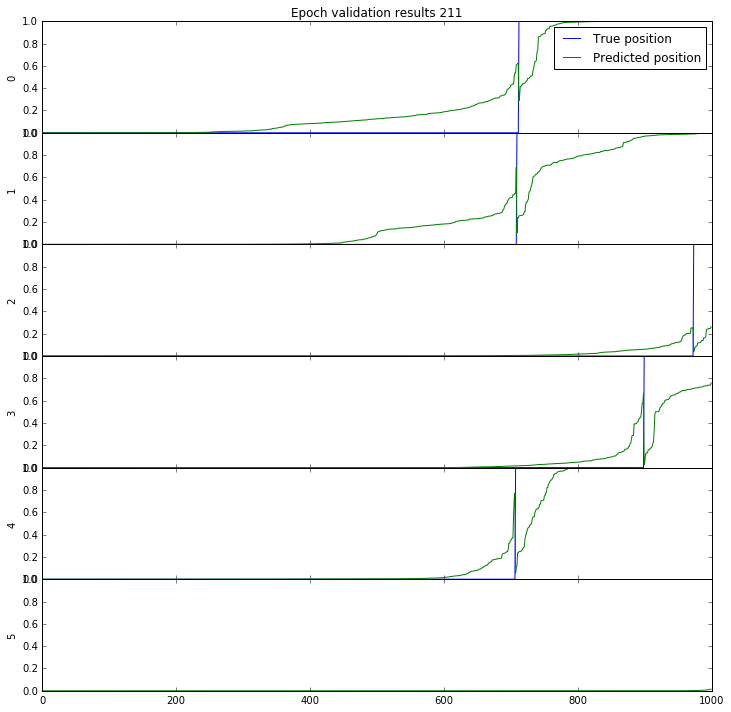

Wrote model to .\Models\models_211.h5
Epoch 212/212
161/161 [==============================] - 53s - loss: 0.5686 - categorical_accuracy: 0.7851 - val_loss: 0.2609 - val_categorical_accuracy: 0.9287
Wrote model to .\Models\models_212.h5
Epoch 213/213
161/161 [==============================] - 52s - loss: 0.5471 - categorical_accuracy: 0.7894 - val_loss: 0.2562 - val_categorical_accuracy: 0.9312
Wrote model to .\Models\models_213.h5
Epoch 214/214
161/161 [==============================] - 53s - loss: 0.5469 - categorical_accuracy: 0.7975 - val_loss: 0.2578 - val_categorical_accuracy: 0.9325
Wrote model to .\Models\models_214.h5
Epoch 215/215
161/161 [==============================] - 53s - loss: 0.5282 - categorical_accuracy: 0.8047 - val_loss: 0.2483 - val_categorical_accuracy: 0.9200
Wrote model to .\Models\models_215.h5
Epoch 216/216
161/161 [==============================] - 53s - loss: 0.5457 - categorical_accuracy: 0.8031 - val_loss: 0.2399 - val_categorical_accuracy: 0.9337
Wrote

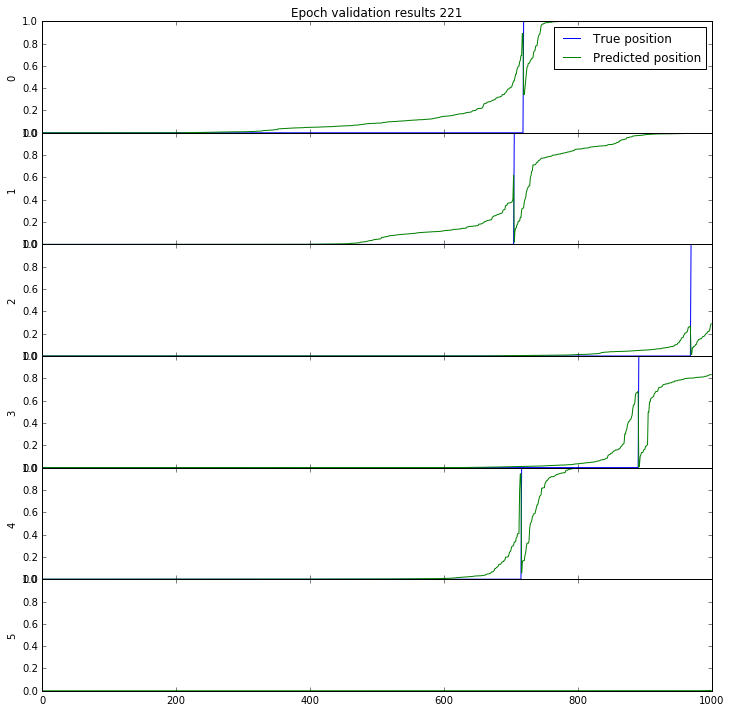

Wrote model to .\Models\models_221.h5
Epoch 222/222
161/161 [==============================] - 52s - loss: 0.5343 - categorical_accuracy: 0.8034 - val_loss: 0.2207 - val_categorical_accuracy: 0.9325
Wrote model to .\Models\models_222.h5
Epoch 223/223
161/161 [==============================] - 52s - loss: 0.5160 - categorical_accuracy: 0.8078 - val_loss: 0.2657 - val_categorical_accuracy: 0.9062
Wrote model to .\Models\models_223.h5
Epoch 224/224
161/161 [==============================] - 53s - loss: 0.5000 - categorical_accuracy: 0.8208 - val_loss: 0.2497 - val_categorical_accuracy: 0.9125
Wrote model to .\Models\models_224.h5
Epoch 225/225
161/161 [==============================] - 52s - loss: 0.5006 - categorical_accuracy: 0.8205 - val_loss: 0.2230 - val_categorical_accuracy: 0.9337
Wrote model to .\Models\models_225.h5
Epoch 226/226
161/161 [==============================] - 53s - loss: 0.4984 - categorical_accuracy: 0.8180 - val_loss: 0.2195 - val_categorical_accuracy: 0.9312
Wrote

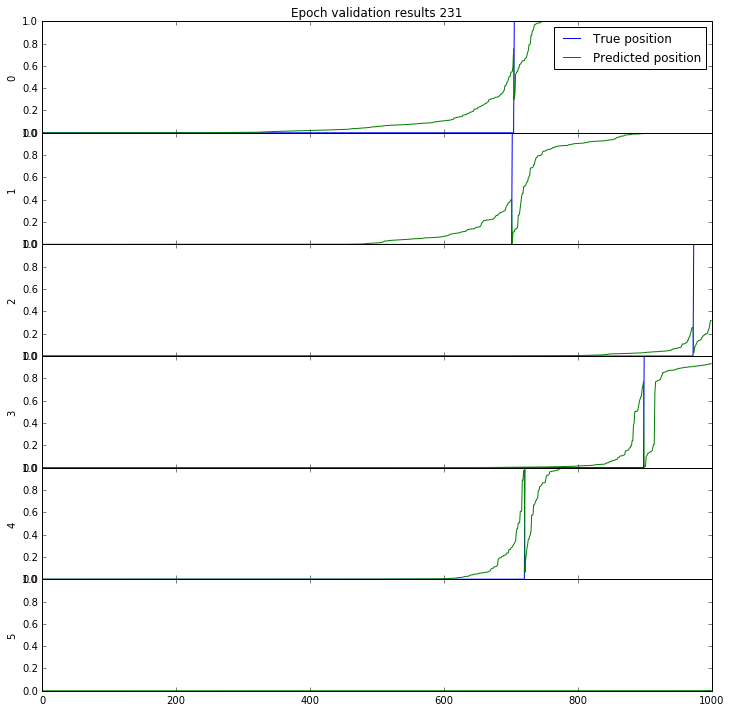

Wrote model to .\Models\models_231.h5
Epoch 232/232
161/161 [==============================] - 53s - loss: 0.4916 - categorical_accuracy: 0.8227 - val_loss: 0.2581 - val_categorical_accuracy: 0.9112
Wrote model to .\Models\models_232.h5
Epoch 233/233
161/161 [==============================] - 54s - loss: 0.4654 - categorical_accuracy: 0.8366 - val_loss: 0.1931 - val_categorical_accuracy: 0.9387
Wrote model to .\Models\models_233.h5
Epoch 234/234
161/161 [==============================] - 53s - loss: 0.4685 - categorical_accuracy: 0.8230 - val_loss: 0.1950 - val_categorical_accuracy: 0.9400
Wrote model to .\Models\models_234.h5
Epoch 235/235
161/161 [==============================] - 53s - loss: 0.4660 - categorical_accuracy: 0.8339 - val_loss: 0.2164 - val_categorical_accuracy: 0.9337
Wrote model to .\Models\models_235.h5
Epoch 236/236
161/161 [==============================] - 53s - loss: 0.4885 - categorical_accuracy: 0.8339 - val_loss: 0.2015 - val_categorical_accuracy: 0.9262
Wrote

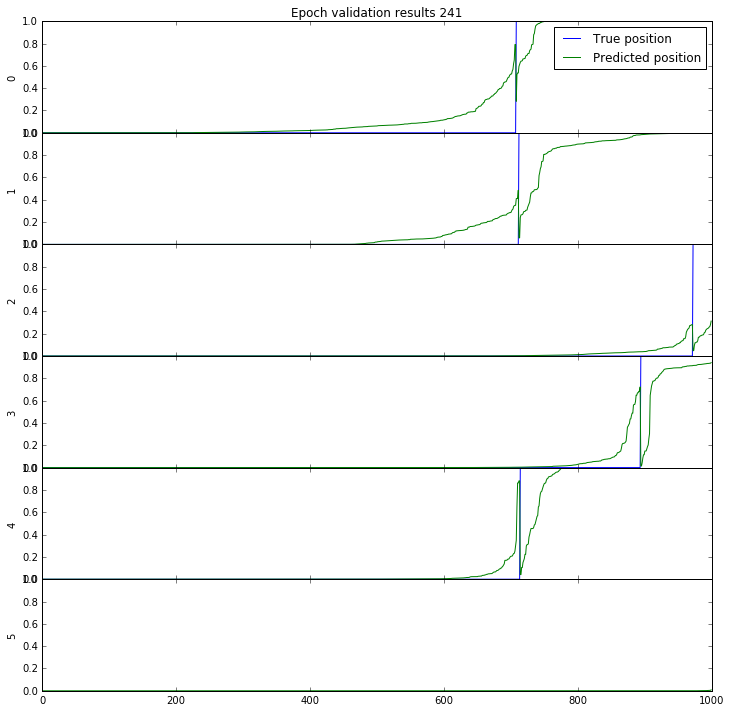

Wrote model to .\Models\models_241.h5
Epoch 242/242
161/161 [==============================] - 53s - loss: 0.4535 - categorical_accuracy: 0.8435 - val_loss: 0.1754 - val_categorical_accuracy: 0.9400
Wrote model to .\Models\models_242.h5
Epoch 243/243
161/161 [==============================] - 53s - loss: 0.4430 - categorical_accuracy: 0.8401 - val_loss: 0.1952 - val_categorical_accuracy: 0.9425
Wrote model to .\Models\models_243.h5
Epoch 244/244
161/161 [==============================] - 53s - loss: 0.4393 - categorical_accuracy: 0.8363 - val_loss: 0.1725 - val_categorical_accuracy: 0.9412
Wrote model to .\Models\models_244.h5
Epoch 245/245
161/161 [==============================] - 53s - loss: 0.4104 - categorical_accuracy: 0.8571 - val_loss: 0.1693 - val_categorical_accuracy: 0.9450
Wrote model to .\Models\models_245.h5
Epoch 246/246
161/161 [==============================] - 53s - loss: 0.4103 - categorical_accuracy: 0.8494 - val_loss: 0.1833 - val_categorical_accuracy: 0.9412
Wrote

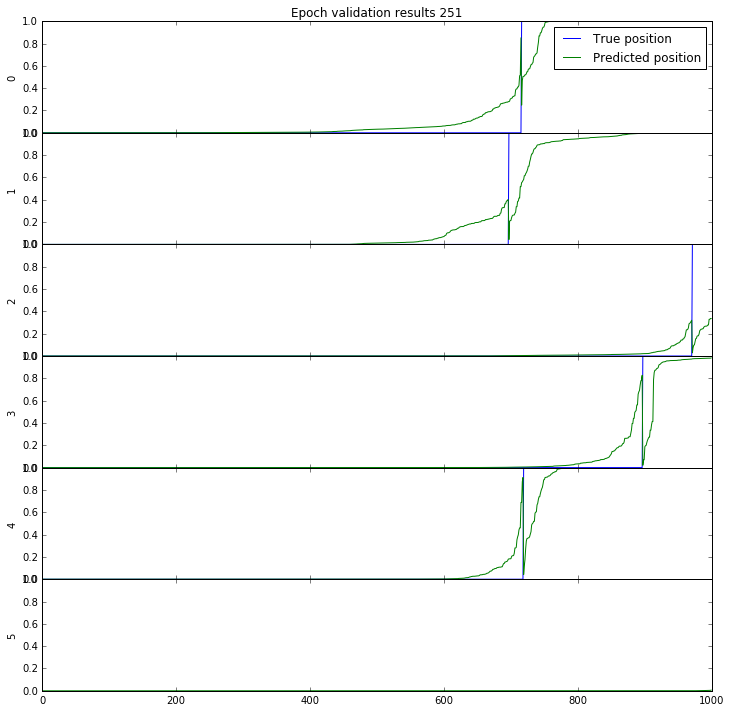

Wrote model to .\Models\models_251.h5
Epoch 252/252
161/161 [==============================] - 52s - loss: 0.4074 - categorical_accuracy: 0.8661 - val_loss: 0.1816 - val_categorical_accuracy: 0.9400
Wrote model to .\Models\models_252.h5
Epoch 253/253
161/161 [==============================] - 54s - loss: 0.4207 - categorical_accuracy: 0.8565 - val_loss: 0.1687 - val_categorical_accuracy: 0.9375
Wrote model to .\Models\models_253.h5
Epoch 254/254
161/161 [==============================] - 53s - loss: 0.4062 - categorical_accuracy: 0.8584 - val_loss: 0.1629 - val_categorical_accuracy: 0.9400
Wrote model to .\Models\models_254.h5
Epoch 255/255
161/161 [==============================] - 53s - loss: 0.4206 - categorical_accuracy: 0.8519 - val_loss: 0.1638 - val_categorical_accuracy: 0.9387
Wrote model to .\Models\models_255.h5
Epoch 256/256
161/161 [==============================] - 53s - loss: 0.4148 - categorical_accuracy: 0.8537 - val_loss: 0.1632 - val_categorical_accuracy: 0.9387
Wrote

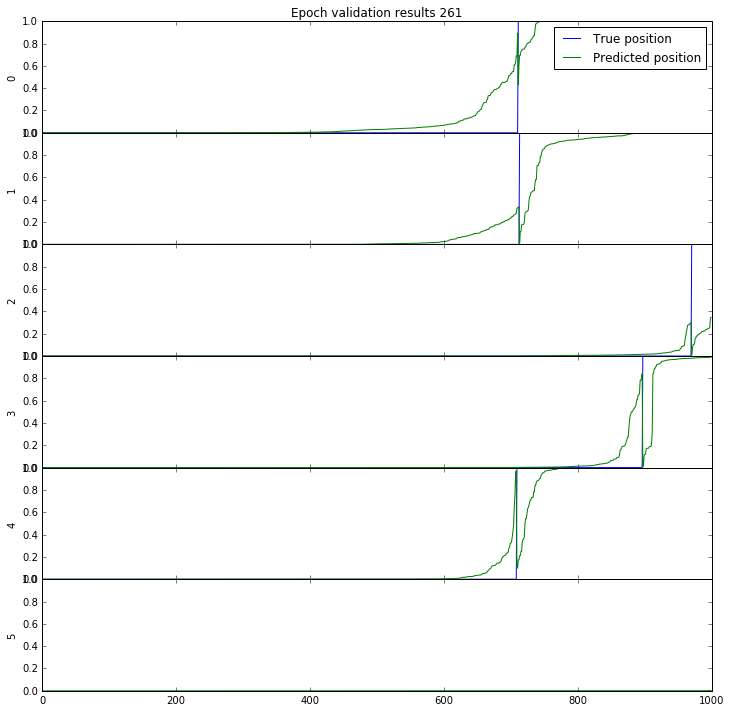

Wrote model to .\Models\models_261.h5
Epoch 262/262
161/161 [==============================] - 53s - loss: 0.3854 - categorical_accuracy: 0.8624 - val_loss: 0.1522 - val_categorical_accuracy: 0.9437
Wrote model to .\Models\models_262.h5
Epoch 263/263
161/161 [==============================] - 53s - loss: 0.3909 - categorical_accuracy: 0.8593 - val_loss: 0.1700 - val_categorical_accuracy: 0.9387
Wrote model to .\Models\models_263.h5
Epoch 264/264
161/161 [==============================] - 53s - loss: 0.3874 - categorical_accuracy: 0.8612 - val_loss: 0.1544 - val_categorical_accuracy: 0.9412
Wrote model to .\Models\models_264.h5
Epoch 265/265
161/161 [==============================] - 53s - loss: 0.3715 - categorical_accuracy: 0.8708 - val_loss: 0.1528 - val_categorical_accuracy: 0.9425
Wrote model to .\Models\models_265.h5
Epoch 266/266
161/161 [==============================] - 53s - loss: 0.3934 - categorical_accuracy: 0.8643 - val_loss: 0.1486 - val_categorical_accuracy: 0.9412
Wrote

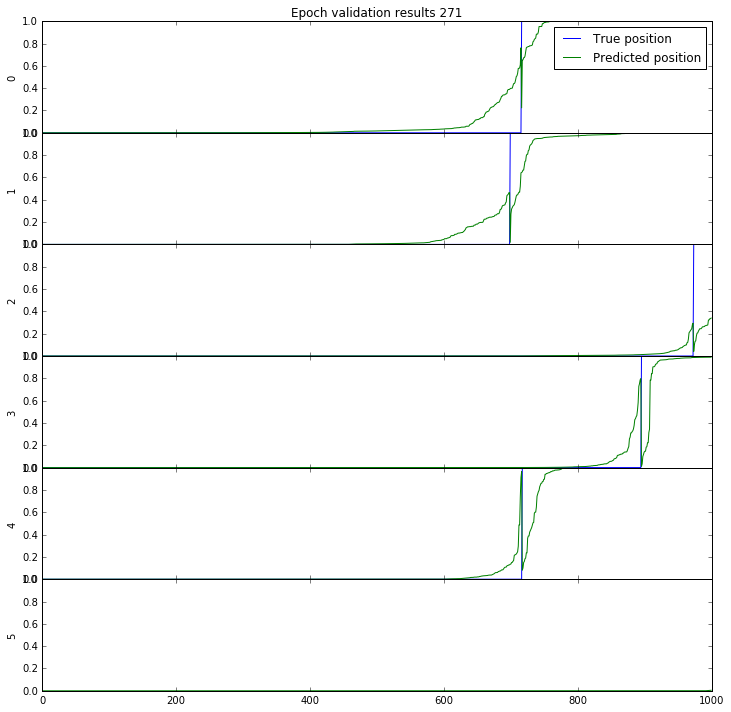

Wrote model to .\Models\models_271.h5
Epoch 272/272
161/161 [==============================] - 53s - loss: 0.3456 - categorical_accuracy: 0.8764 - val_loss: 0.1415 - val_categorical_accuracy: 0.9500
Wrote model to .\Models\models_272.h5
Epoch 273/273
161/161 [==============================] - 53s - loss: 0.3831 - categorical_accuracy: 0.8683 - val_loss: 0.1554 - val_categorical_accuracy: 0.9450
Wrote model to .\Models\models_273.h5
Epoch 274/274
161/161 [==============================] - 53s - loss: 0.3698 - categorical_accuracy: 0.8677 - val_loss: 0.1350 - val_categorical_accuracy: 0.9500
Wrote model to .\Models\models_274.h5
Epoch 275/275
161/161 [==============================] - 53s - loss: 0.3602 - categorical_accuracy: 0.8724 - val_loss: 0.1501 - val_categorical_accuracy: 0.9462
Wrote model to .\Models\models_275.h5
Epoch 276/276
161/161 [==============================] - 53s - loss: 0.3682 - categorical_accuracy: 0.8739 - val_loss: 0.1347 - val_categorical_accuracy: 0.9500
Wrote

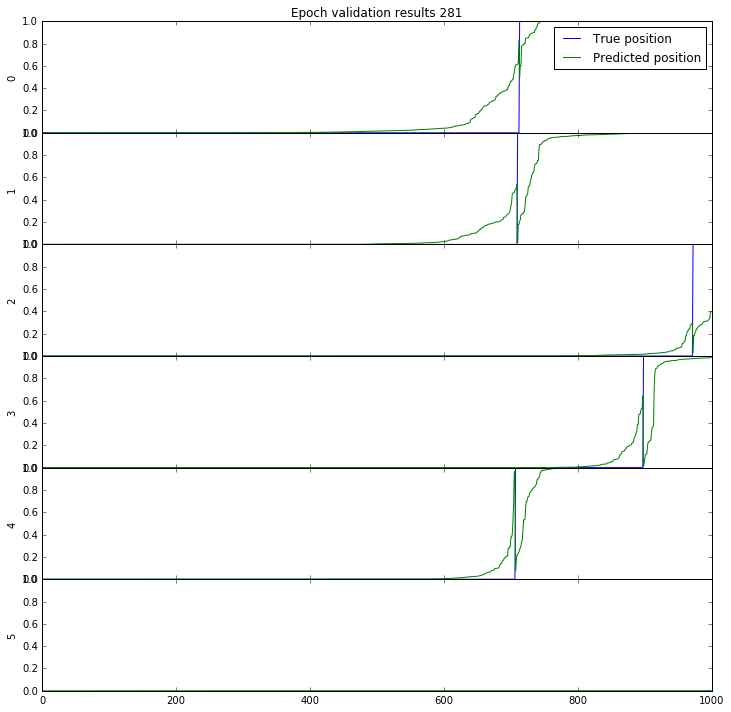

Wrote model to .\Models\models_281.h5
Epoch 282/282
161/161 [==============================] - 52s - loss: 0.3570 - categorical_accuracy: 0.8829 - val_loss: 0.1394 - val_categorical_accuracy: 0.9462
Wrote model to .\Models\models_282.h5
Epoch 283/283
161/161 [==============================] - 52s - loss: 0.3519 - categorical_accuracy: 0.8755 - val_loss: 0.1356 - val_categorical_accuracy: 0.9537
Wrote model to .\Models\models_283.h5
Epoch 284/284
161/161 [==============================] - 53s - loss: 0.3601 - categorical_accuracy: 0.8742 - val_loss: 0.1317 - val_categorical_accuracy: 0.9487
Wrote model to .\Models\models_284.h5
Epoch 285/285
161/161 [==============================] - 52s - loss: 0.3358 - categorical_accuracy: 0.8845 - val_loss: 0.1292 - val_categorical_accuracy: 0.9537
Wrote model to .\Models\models_285.h5
Epoch 286/286
161/161 [==============================] - 53s - loss: 0.3446 - categorical_accuracy: 0.8835 - val_loss: 0.1361 - val_categorical_accuracy: 0.9462
Wrote

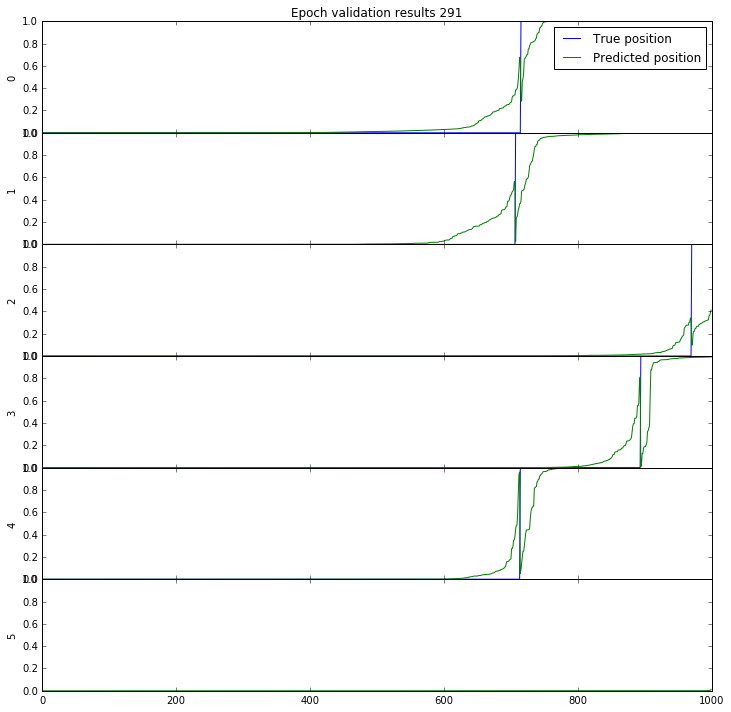

Wrote model to .\Models\models_291.h5
Epoch 292/292
161/161 [==============================] - 53s - loss: 0.3365 - categorical_accuracy: 0.8851 - val_loss: 0.1246 - val_categorical_accuracy: 0.9562
Wrote model to .\Models\models_292.h5
Epoch 293/293
161/161 [==============================] - 53s - loss: 0.3323 - categorical_accuracy: 0.8823 - val_loss: 0.1230 - val_categorical_accuracy: 0.9587
Wrote model to .\Models\models_293.h5
Epoch 294/294
161/161 [==============================] - 53s - loss: 0.3321 - categorical_accuracy: 0.8823 - val_loss: 0.1394 - val_categorical_accuracy: 0.9525
Wrote model to .\Models\models_294.h5
Epoch 295/295
161/161 [==============================] - 53s - loss: 0.3384 - categorical_accuracy: 0.8817 - val_loss: 0.1324 - val_categorical_accuracy: 0.9487
Wrote model to .\Models\models_295.h5
Epoch 296/296
161/161 [==============================] - 53s - loss: 0.3312 - categorical_accuracy: 0.8888 - val_loss: 0.1283 - val_categorical_accuracy: 0.9550
Wrote

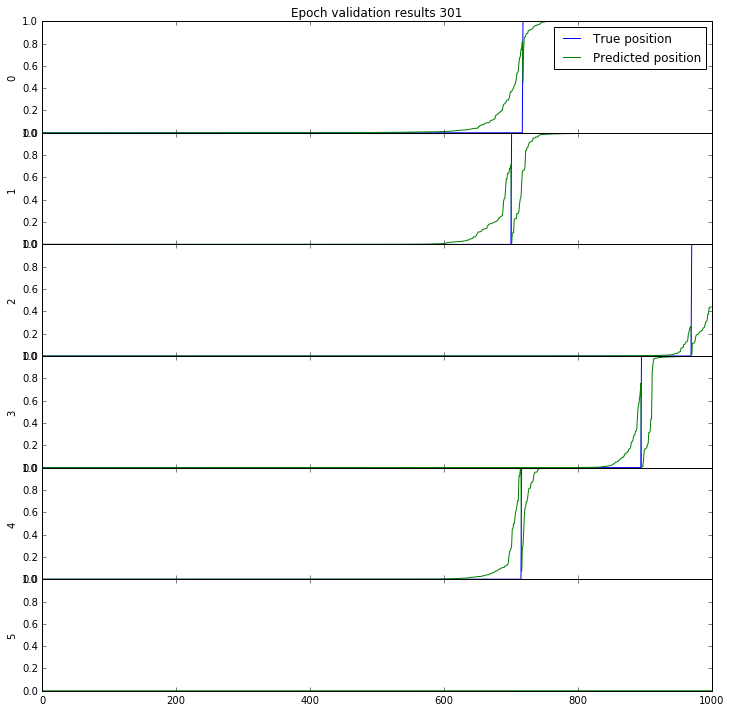

Wrote model to .\Models\models_301.h5
Epoch 302/302
161/161 [==============================] - 53s - loss: 0.3336 - categorical_accuracy: 0.8863 - val_loss: 0.1213 - val_categorical_accuracy: 0.9525
Wrote model to .\Models\models_302.h5
Epoch 303/303
161/161 [==============================] - 53s - loss: 0.2995 - categorical_accuracy: 0.8944 - val_loss: 0.1163 - val_categorical_accuracy: 0.9587
Wrote model to .\Models\models_303.h5
Epoch 304/304
161/161 [==============================] - 53s - loss: 0.3235 - categorical_accuracy: 0.8870 - val_loss: 0.1302 - val_categorical_accuracy: 0.9562
Wrote model to .\Models\models_304.h5
Epoch 305/305
161/161 [==============================] - 53s - loss: 0.3278 - categorical_accuracy: 0.8860 - val_loss: 0.1368 - val_categorical_accuracy: 0.9550
Wrote model to .\Models\models_305.h5
Epoch 306/306
161/161 [==============================] - 53s - loss: 0.3236 - categorical_accuracy: 0.8929 - val_loss: 0.1225 - val_categorical_accuracy: 0.9550
Wrote

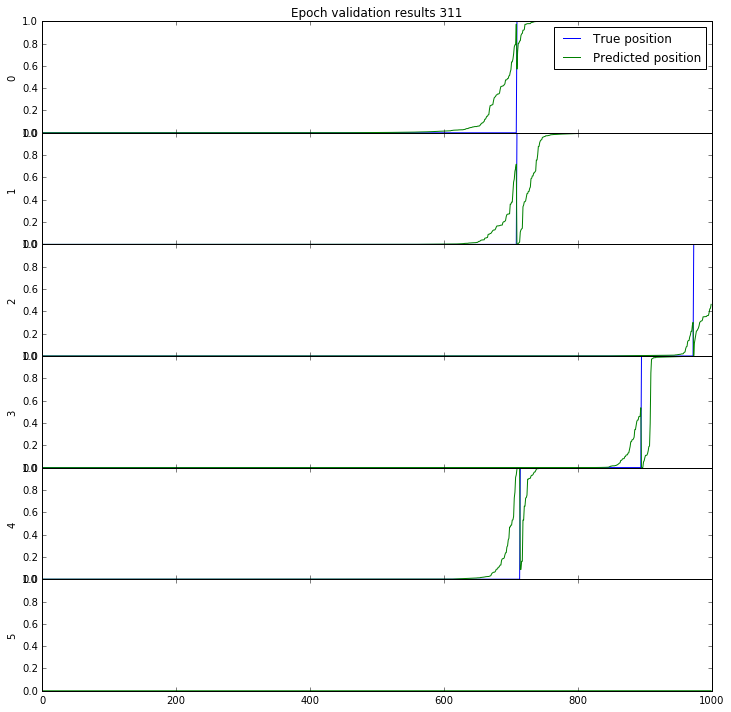

Wrote model to .\Models\models_311.h5
Epoch 312/312
161/161 [==============================] - 52s - loss: 0.3088 - categorical_accuracy: 0.8947 - val_loss: 0.1166 - val_categorical_accuracy: 0.9662
Wrote model to .\Models\models_312.h5
Epoch 313/313
161/161 [==============================] - 53s - loss: 0.3020 - categorical_accuracy: 0.8913 - val_loss: 0.1169 - val_categorical_accuracy: 0.9612
Wrote model to .\Models\models_313.h5
Epoch 314/314
161/161 [==============================] - 53s - loss: 0.3011 - categorical_accuracy: 0.8950 - val_loss: 0.1271 - val_categorical_accuracy: 0.9500
Wrote model to .\Models\models_314.h5
Epoch 315/315
161/161 [==============================] - 53s - loss: 0.3045 - categorical_accuracy: 0.8929 - val_loss: 0.1197 - val_categorical_accuracy: 0.9525
Wrote model to .\Models\models_315.h5
Epoch 316/316
161/161 [==============================] - 53s - loss: 0.3081 - categorical_accuracy: 0.8941 - val_loss: 0.1335 - val_categorical_accuracy: 0.9462
Wrote

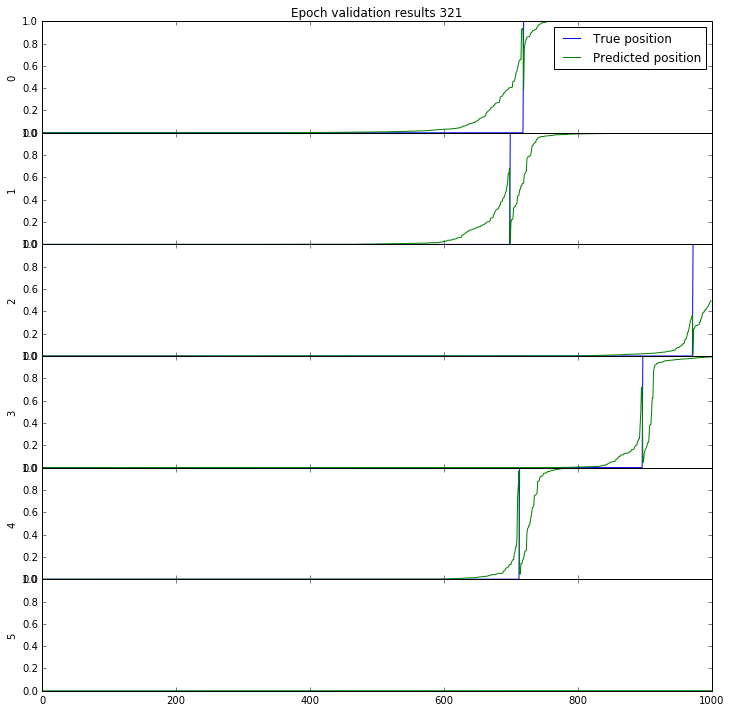

Wrote model to .\Models\models_321.h5
Epoch 322/322
161/161 [==============================] - 53s - loss: 0.3041 - categorical_accuracy: 0.8938 - val_loss: 0.1119 - val_categorical_accuracy: 0.9662
Wrote model to .\Models\models_322.h5
Epoch 323/323
161/161 [==============================] - 54s - loss: 0.3161 - categorical_accuracy: 0.8953 - val_loss: 0.1107 - val_categorical_accuracy: 0.9625
Wrote model to .\Models\models_323.h5
Epoch 324/324
161/161 [==============================] - 53s - loss: 0.2898 - categorical_accuracy: 0.9025 - val_loss: 0.1112 - val_categorical_accuracy: 0.9625
Wrote model to .\Models\models_324.h5
Epoch 325/325
161/161 [==============================] - 53s - loss: 0.2995 - categorical_accuracy: 0.9006 - val_loss: 0.1121 - val_categorical_accuracy: 0.9587
Wrote model to .\Models\models_325.h5
Epoch 326/326
161/161 [==============================] - 53s - loss: 0.2791 - categorical_accuracy: 0.9019 - val_loss: 0.1172 - val_categorical_accuracy: 0.9550
Wrote

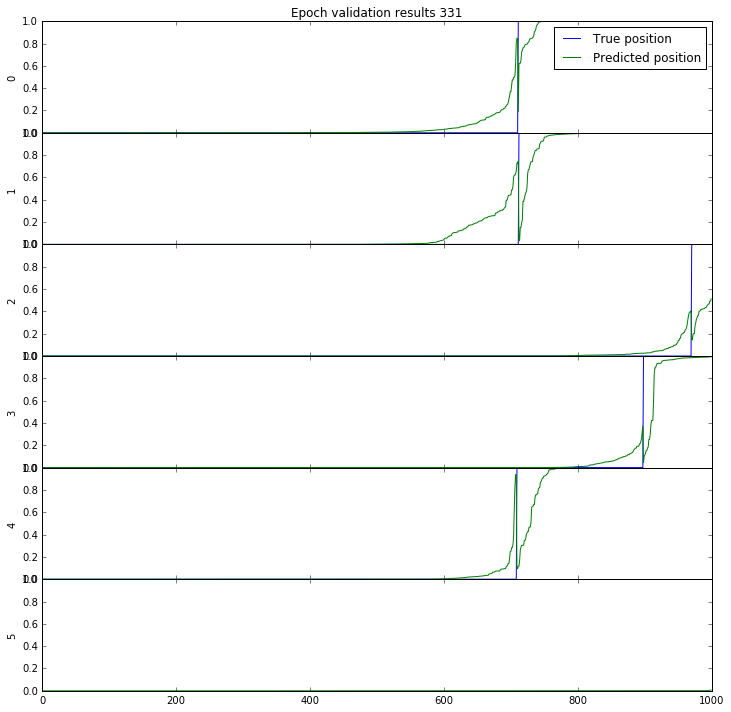

Wrote model to .\Models\models_331.h5
Epoch 332/332
161/161 [==============================] - 53s - loss: 0.2846 - categorical_accuracy: 0.8984 - val_loss: 0.1078 - val_categorical_accuracy: 0.9650
Wrote model to .\Models\models_332.h5
Epoch 333/333
161/161 [==============================] - 53s - loss: 0.2893 - categorical_accuracy: 0.9016 - val_loss: 0.1176 - val_categorical_accuracy: 0.9525
Wrote model to .\Models\models_333.h5
Epoch 334/334
161/161 [==============================] - 53s - loss: 0.2731 - categorical_accuracy: 0.9022 - val_loss: 0.1160 - val_categorical_accuracy: 0.9637
Wrote model to .\Models\models_334.h5
Epoch 335/335
161/161 [==============================] - 53s - loss: 0.2574 - categorical_accuracy: 0.9102 - val_loss: 0.1133 - val_categorical_accuracy: 0.9612
Wrote model to .\Models\models_335.h5
Epoch 336/336
161/161 [==============================] - 53s - loss: 0.2715 - categorical_accuracy: 0.9040 - val_loss: 0.1107 - val_categorical_accuracy: 0.9687
Wrote

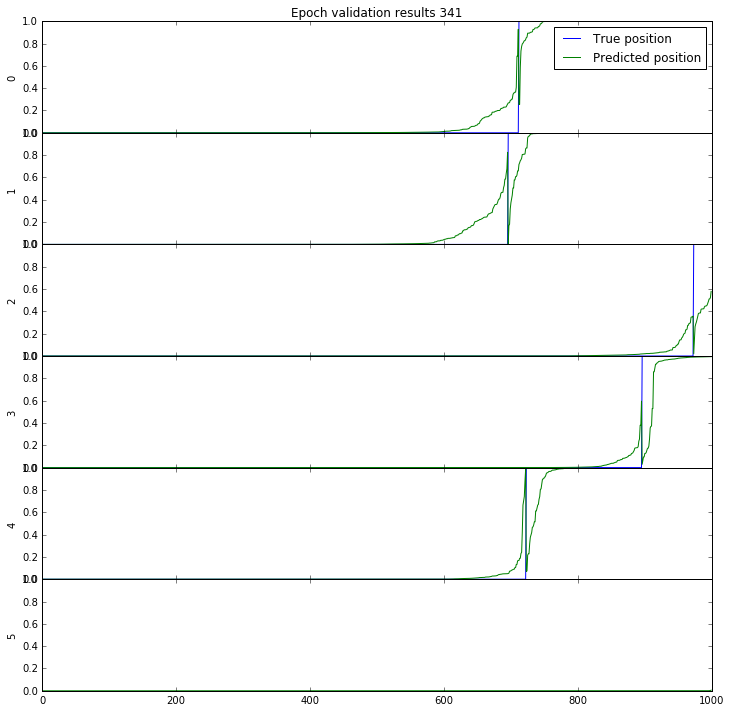

Wrote model to .\Models\models_341.h5
Epoch 342/342
161/161 [==============================] - 53s - loss: 0.2787 - categorical_accuracy: 0.9071 - val_loss: 0.1080 - val_categorical_accuracy: 0.9725
Wrote model to .\Models\models_342.h5
Epoch 343/343
161/161 [==============================] - 54s - loss: 0.3023 - categorical_accuracy: 0.8984 - val_loss: 0.1324 - val_categorical_accuracy: 0.9637
Wrote model to .\Models\models_343.h5
Epoch 344/344
161/161 [==============================] - 53s - loss: 0.2744 - categorical_accuracy: 0.9031 - val_loss: 0.1165 - val_categorical_accuracy: 0.9612
Wrote model to .\Models\models_344.h5
Epoch 345/345
161/161 [==============================] - 54s - loss: 0.2920 - categorical_accuracy: 0.9047 - val_loss: 0.1135 - val_categorical_accuracy: 0.9600
Wrote model to .\Models\models_345.h5
Epoch 346/346
161/161 [==============================] - 53s - loss: 0.2990 - categorical_accuracy: 0.9006 - val_loss: 0.1071 - val_categorical_accuracy: 0.9687
Wrote

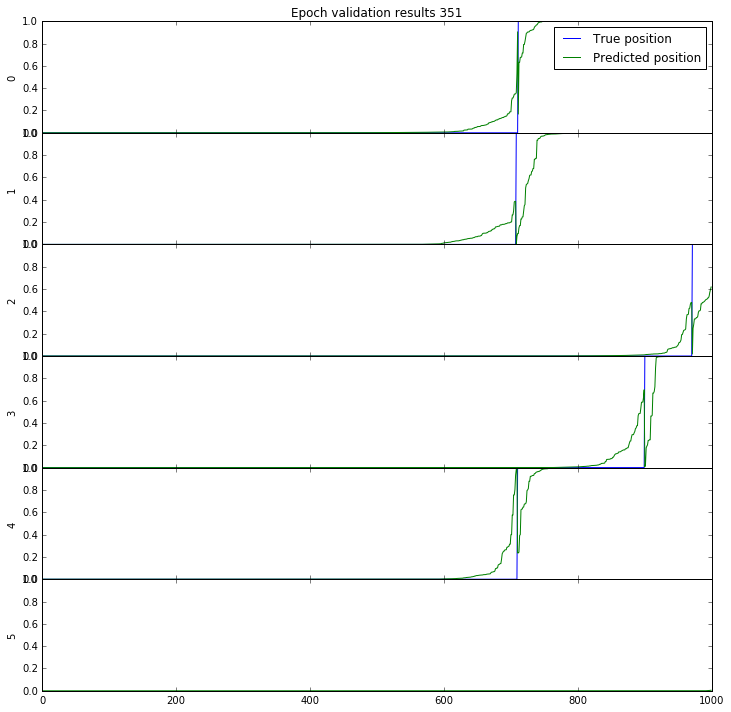

Wrote model to .\Models\models_351.h5
Epoch 352/352
161/161 [==============================] - 53s - loss: 0.2781 - categorical_accuracy: 0.9071 - val_loss: 0.0977 - val_categorical_accuracy: 0.9750
Wrote model to .\Models\models_352.h5
Epoch 353/353
161/161 [==============================] - 53s - loss: 0.2747 - categorical_accuracy: 0.9050 - val_loss: 0.1119 - val_categorical_accuracy: 0.9700
Wrote model to .\Models\models_353.h5
Epoch 354/354
161/161 [==============================] - 53s - loss: 0.2612 - categorical_accuracy: 0.9056 - val_loss: 0.0916 - val_categorical_accuracy: 0.9700
Wrote model to .\Models\models_354.h5
Epoch 355/355
161/161 [==============================] - 54s - loss: 0.2943 - categorical_accuracy: 0.9040 - val_loss: 0.1025 - val_categorical_accuracy: 0.9712
Wrote model to .\Models\models_355.h5
Epoch 356/356
161/161 [==============================] - 53s - loss: 0.2621 - categorical_accuracy: 0.9130 - val_loss: 0.1032 - val_categorical_accuracy: 0.9712
Wrote

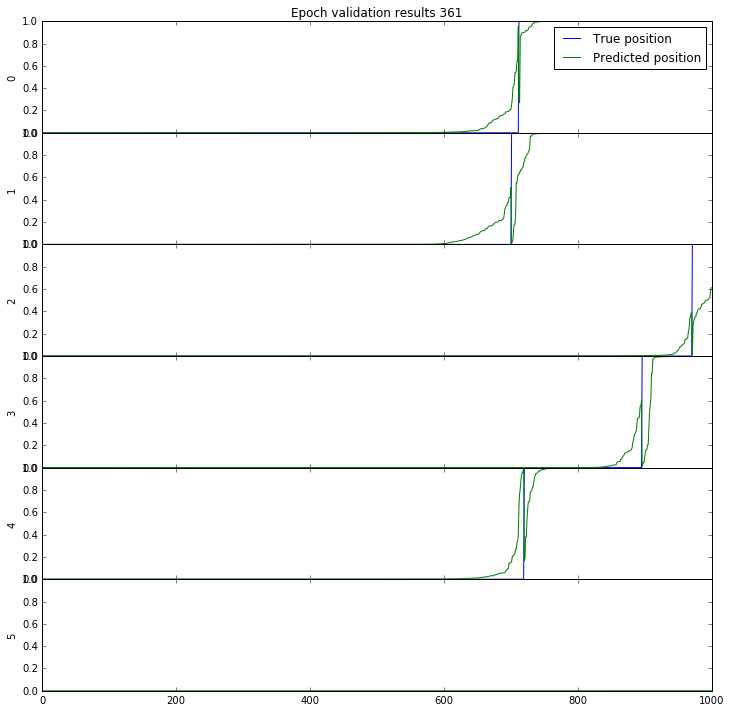

Wrote model to .\Models\models_361.h5
Epoch 362/362
161/161 [==============================] - 52s - loss: 0.2699 - categorical_accuracy: 0.9053 - val_loss: 0.1063 - val_categorical_accuracy: 0.9687
Wrote model to .\Models\models_362.h5
Epoch 363/363
161/161 [==============================] - 53s - loss: 0.2544 - categorical_accuracy: 0.9130 - val_loss: 0.0986 - val_categorical_accuracy: 0.9662
Wrote model to .\Models\models_363.h5
Epoch 364/364
161/161 [==============================] - 53s - loss: 0.2591 - categorical_accuracy: 0.9158 - val_loss: 0.1033 - val_categorical_accuracy: 0.9662
Wrote model to .\Models\models_364.h5
Epoch 365/365
161/161 [==============================] - 53s - loss: 0.2632 - categorical_accuracy: 0.9112 - val_loss: 0.1100 - val_categorical_accuracy: 0.9675
Wrote model to .\Models\models_365.h5
Epoch 366/366
161/161 [==============================] - 53s - loss: 0.2555 - categorical_accuracy: 0.9152 - val_loss: 0.1156 - val_categorical_accuracy: 0.9675
Wrote

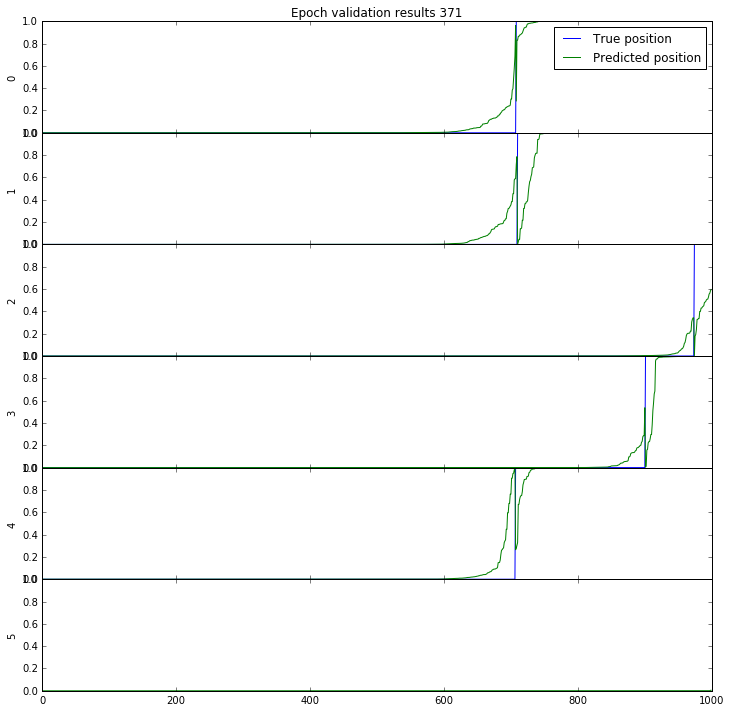

Wrote model to .\Models\models_371.h5
Epoch 372/372
161/161 [==============================] - 53s - loss: 0.2627 - categorical_accuracy: 0.9099 - val_loss: 0.1048 - val_categorical_accuracy: 0.9712
Wrote model to .\Models\models_372.h5
Epoch 373/373
161/161 [==============================] - 53s - loss: 0.2567 - categorical_accuracy: 0.9165 - val_loss: 0.1121 - val_categorical_accuracy: 0.9662
Wrote model to .\Models\models_373.h5
Epoch 374/374
161/161 [==============================] - 53s - loss: 0.2606 - categorical_accuracy: 0.9134 - val_loss: 0.1013 - val_categorical_accuracy: 0.9712
Wrote model to .\Models\models_374.h5
Epoch 375/375
161/161 [==============================] - 54s - loss: 0.2492 - categorical_accuracy: 0.9174 - val_loss: 0.0974 - val_categorical_accuracy: 0.9675
Wrote model to .\Models\models_375.h5
Epoch 376/376
161/161 [==============================] - 53s - loss: 0.2413 - categorical_accuracy: 0.9171 - val_loss: 0.0971 - val_categorical_accuracy: 0.9737
Wrote

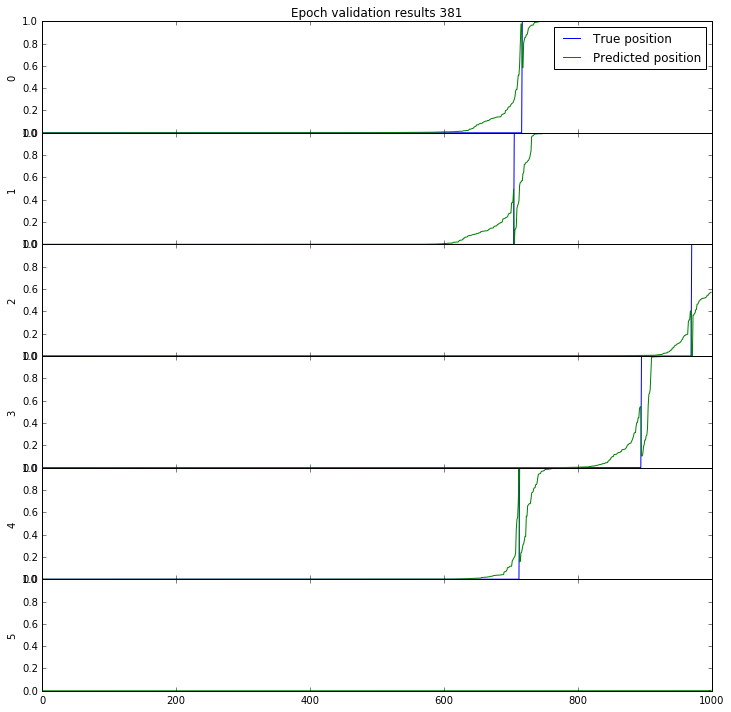

Wrote model to .\Models\models_381.h5
Epoch 382/382
161/161 [==============================] - 53s - loss: 0.2536 - categorical_accuracy: 0.9183 - val_loss: 0.0950 - val_categorical_accuracy: 0.9662
Wrote model to .\Models\models_382.h5
Epoch 383/383
161/161 [==============================] - 53s - loss: 0.2552 - categorical_accuracy: 0.9146 - val_loss: 0.0916 - val_categorical_accuracy: 0.9662
Wrote model to .\Models\models_383.h5
Epoch 384/384
161/161 [==============================] - 53s - loss: 0.2493 - categorical_accuracy: 0.9115 - val_loss: 0.0958 - val_categorical_accuracy: 0.9737
Wrote model to .\Models\models_384.h5
Epoch 385/385
161/161 [==============================] - 54s - loss: 0.2561 - categorical_accuracy: 0.9199 - val_loss: 0.1024 - val_categorical_accuracy: 0.9637
Wrote model to .\Models\models_385.h5
Epoch 386/386
161/161 [==============================] - 53s - loss: 0.2282 - categorical_accuracy: 0.9155 - val_loss: 0.1170 - val_categorical_accuracy: 0.9587
Wrote

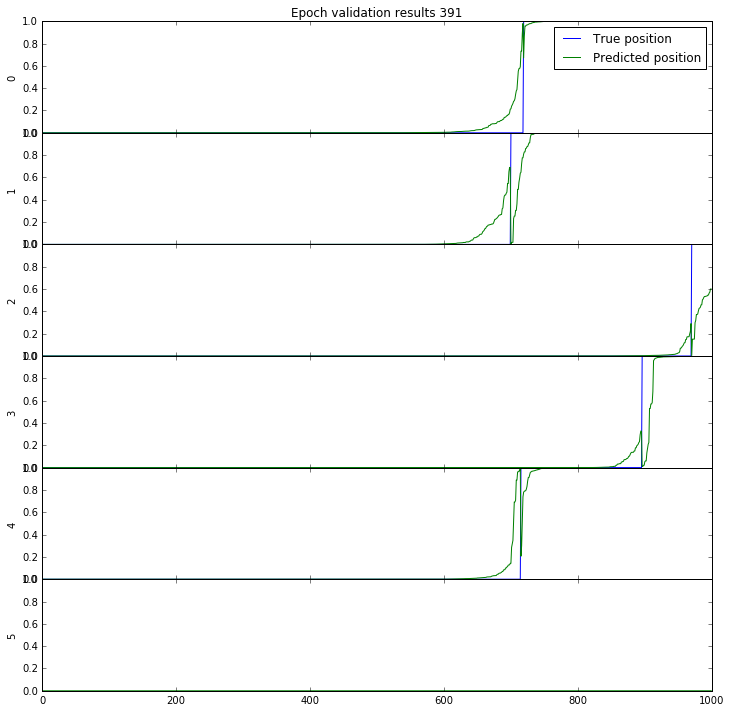

Wrote model to .\Models\models_391.h5
Epoch 392/392
161/161 [==============================] - 54s - loss: 0.2375 - categorical_accuracy: 0.9174 - val_loss: 0.0894 - val_categorical_accuracy: 0.9775
Wrote model to .\Models\models_392.h5
Epoch 393/393
161/161 [==============================] - 53s - loss: 0.2470 - categorical_accuracy: 0.9112 - val_loss: 0.0938 - val_categorical_accuracy: 0.9712
Wrote model to .\Models\models_393.h5
Epoch 394/394
161/161 [==============================] - 53s - loss: 0.2263 - categorical_accuracy: 0.9214 - val_loss: 0.0919 - val_categorical_accuracy: 0.9762
Wrote model to .\Models\models_394.h5
Epoch 395/395
161/161 [==============================] - 53s - loss: 0.2504 - categorical_accuracy: 0.9174 - val_loss: 0.0886 - val_categorical_accuracy: 0.9775
Wrote model to .\Models\models_395.h5
Epoch 396/396
161/161 [==============================] - 52s - loss: 0.2480 - categorical_accuracy: 0.9180 - val_loss: 0.1136 - val_categorical_accuracy: 0.9737
Wrote

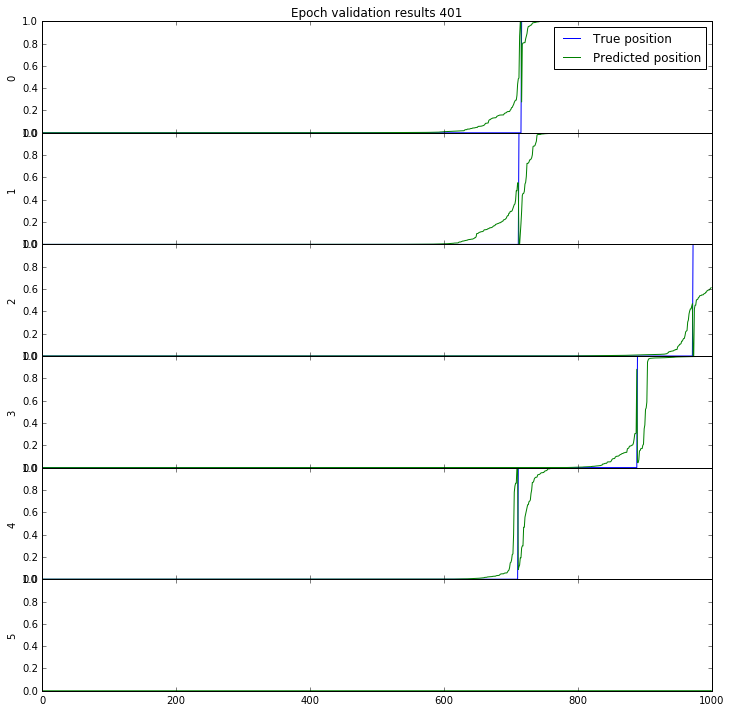

Wrote model to .\Models\models_401.h5
Epoch 402/402
161/161 [==============================] - 53s - loss: 0.2323 - categorical_accuracy: 0.9208 - val_loss: 0.0938 - val_categorical_accuracy: 0.9737
Wrote model to .\Models\models_402.h5
Epoch 403/403
161/161 [==============================] - 53s - loss: 0.2320 - categorical_accuracy: 0.9270 - val_loss: 0.0989 - val_categorical_accuracy: 0.9775
Wrote model to .\Models\models_403.h5
Epoch 404/404
161/161 [==============================] - 54s - loss: 0.2265 - categorical_accuracy: 0.9236 - val_loss: 0.0939 - val_categorical_accuracy: 0.9787
Wrote model to .\Models\models_404.h5
Epoch 405/405
161/161 [==============================] - 53s - loss: 0.2392 - categorical_accuracy: 0.9171 - val_loss: 0.0889 - val_categorical_accuracy: 0.9762
Wrote model to .\Models\models_405.h5
Epoch 406/406
161/161 [==============================] - 54s - loss: 0.2250 - categorical_accuracy: 0.9174 - val_loss: 0.0924 - val_categorical_accuracy: 0.9750
Wrote

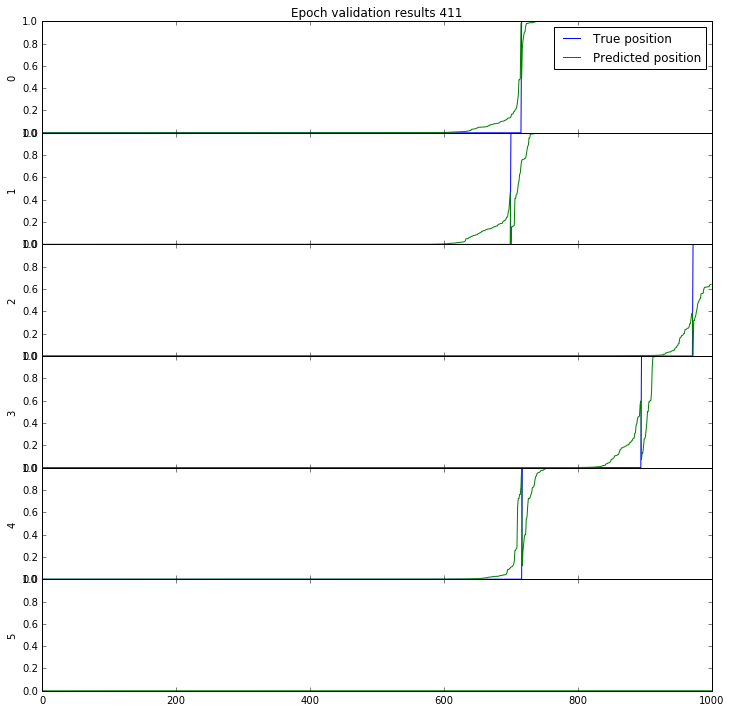

Wrote model to .\Models\models_411.h5
Epoch 412/412
161/161 [==============================] - 53s - loss: 0.2436 - categorical_accuracy: 0.9211 - val_loss: 0.1121 - val_categorical_accuracy: 0.9700
Wrote model to .\Models\models_412.h5
Epoch 413/413
161/161 [==============================] - 53s - loss: 0.2194 - categorical_accuracy: 0.9224 - val_loss: 0.0891 - val_categorical_accuracy: 0.9700
Wrote model to .\Models\models_413.h5
Epoch 414/414
161/161 [==============================] - 54s - loss: 0.2265 - categorical_accuracy: 0.9214 - val_loss: 0.0943 - val_categorical_accuracy: 0.9762
Wrote model to .\Models\models_414.h5
Epoch 415/415
161/161 [==============================] - 52s - loss: 0.2318 - categorical_accuracy: 0.9239 - val_loss: 0.0880 - val_categorical_accuracy: 0.9737
Wrote model to .\Models\models_415.h5
Epoch 416/416
161/161 [==============================] - 53s - loss: 0.2155 - categorical_accuracy: 0.9317 - val_loss: 0.0952 - val_categorical_accuracy: 0.9725
Wrote

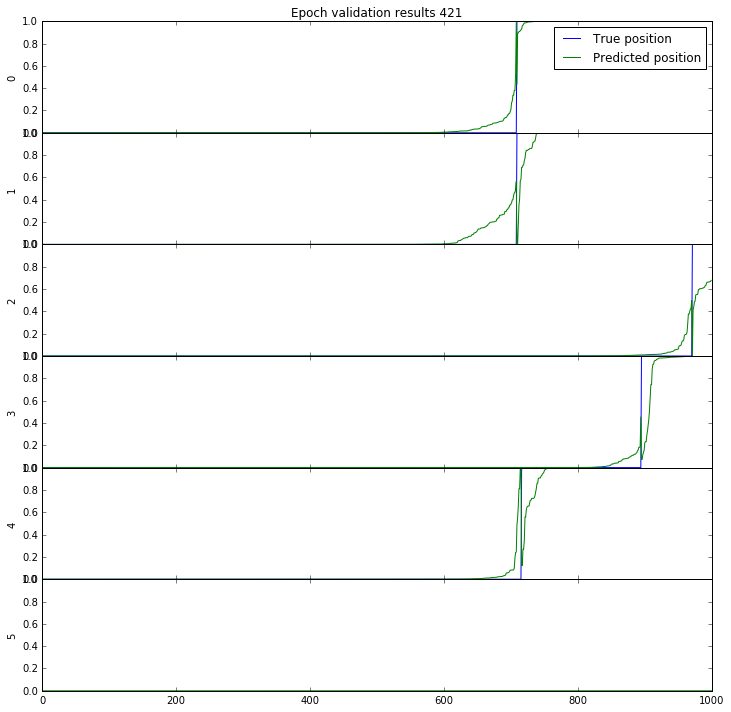

Wrote model to .\Models\models_421.h5
Epoch 422/422
161/161 [==============================] - 54s - loss: 0.2113 - categorical_accuracy: 0.9301 - val_loss: 0.0755 - val_categorical_accuracy: 0.9775
Wrote model to .\Models\models_422.h5
Epoch 423/423
161/161 [==============================] - 53s - loss: 0.2429 - categorical_accuracy: 0.9189 - val_loss: 0.0850 - val_categorical_accuracy: 0.9800
Wrote model to .\Models\models_423.h5
Epoch 424/424
161/161 [==============================] - 53s - loss: 0.2247 - categorical_accuracy: 0.9180 - val_loss: 0.0954 - val_categorical_accuracy: 0.9775
Wrote model to .\Models\models_424.h5
Epoch 425/425
161/161 [==============================] - 53s - loss: 0.2145 - categorical_accuracy: 0.9264 - val_loss: 0.0835 - val_categorical_accuracy: 0.9762
Wrote model to .\Models\models_425.h5
Epoch 426/426
161/161 [==============================] - 52s - loss: 0.2167 - categorical_accuracy: 0.9295 - val_loss: 0.0945 - val_categorical_accuracy: 0.9737
Wrote

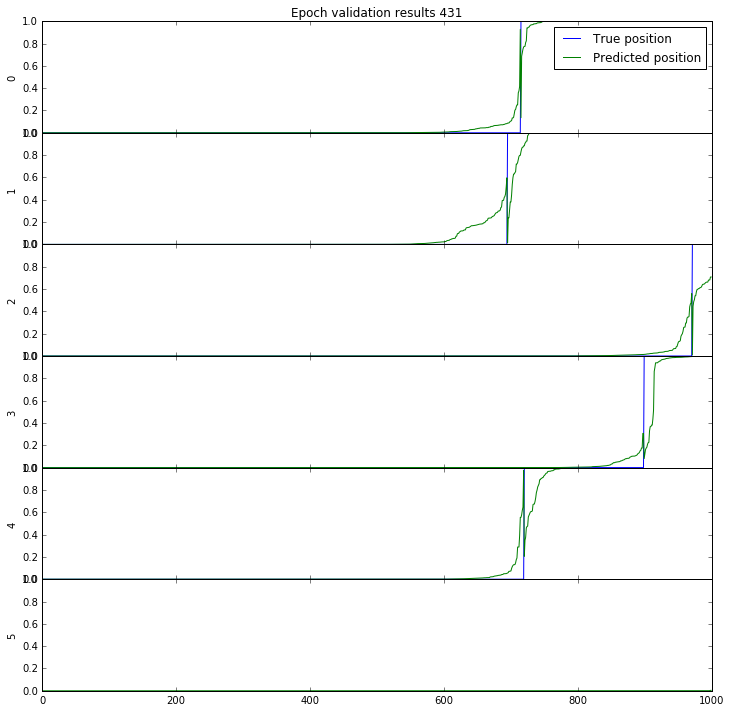

Wrote model to .\Models\models_431.h5
Epoch 432/432
161/161 [==============================] - 53s - loss: 0.2129 - categorical_accuracy: 0.9273 - val_loss: 0.0798 - val_categorical_accuracy: 0.9775
Wrote model to .\Models\models_432.h5
Epoch 433/433
161/161 [==============================] - 53s - loss: 0.2181 - categorical_accuracy: 0.9280 - val_loss: 0.0854 - val_categorical_accuracy: 0.9712
Wrote model to .\Models\models_433.h5
Epoch 434/434
161/161 [==============================] - 53s - loss: 0.2059 - categorical_accuracy: 0.9339 - val_loss: 0.0732 - val_categorical_accuracy: 0.9762
Wrote model to .\Models\models_434.h5
Epoch 435/435
161/161 [==============================] - 54s - loss: 0.2266 - categorical_accuracy: 0.9217 - val_loss: 0.0823 - val_categorical_accuracy: 0.9775
Wrote model to .\Models\models_435.h5
Epoch 436/436
161/161 [==============================] - 52s - loss: 0.1979 - categorical_accuracy: 0.9320 - val_loss: 0.0747 - val_categorical_accuracy: 0.9800
Wrote

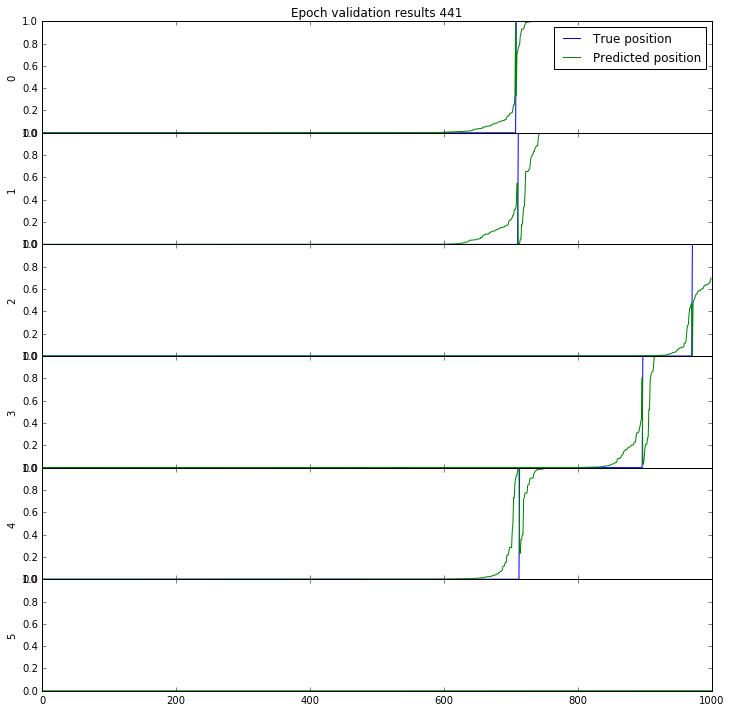

Wrote model to .\Models\models_441.h5
Epoch 442/442
161/161 [==============================] - 53s - loss: 0.2060 - categorical_accuracy: 0.9295 - val_loss: 0.0876 - val_categorical_accuracy: 0.9637
Wrote model to .\Models\models_442.h5
Epoch 443/443
161/161 [==============================] - 53s - loss: 0.2112 - categorical_accuracy: 0.9307 - val_loss: 0.0713 - val_categorical_accuracy: 0.9787
Wrote model to .\Models\models_443.h5
Epoch 444/444
161/161 [==============================] - 53s - loss: 0.1993 - categorical_accuracy: 0.9335 - val_loss: 0.1144 - val_categorical_accuracy: 0.9700
Wrote model to .\Models\models_444.h5
Epoch 445/445
161/161 [==============================] - 53s - loss: 0.2113 - categorical_accuracy: 0.9283 - val_loss: 0.0895 - val_categorical_accuracy: 0.9787
Wrote model to .\Models\models_445.h5
Epoch 446/446
161/161 [==============================] - 53s - loss: 0.1982 - categorical_accuracy: 0.9339 - val_loss: 0.0810 - val_categorical_accuracy: 0.9775
Wrote

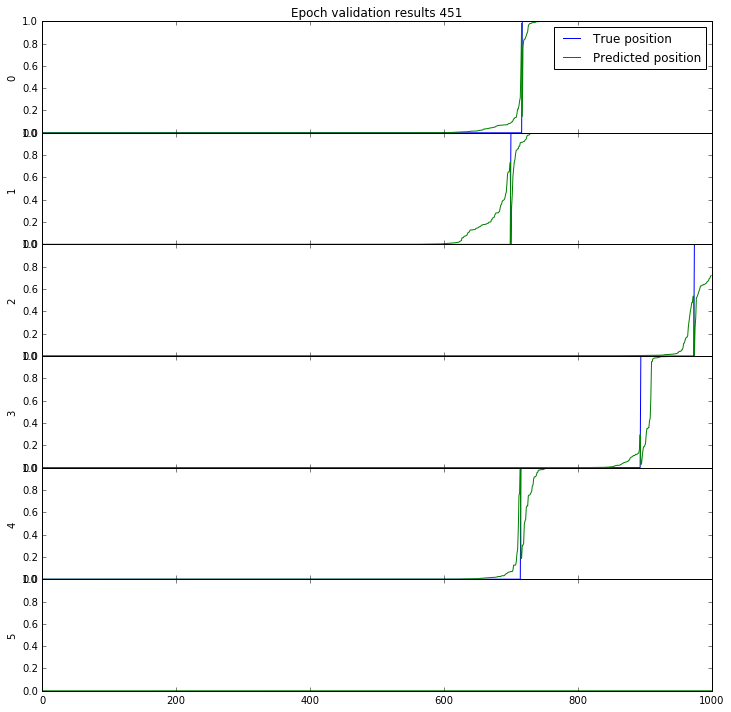

Wrote model to .\Models\models_451.h5
Epoch 452/452
161/161 [==============================] - 53s - loss: 0.1861 - categorical_accuracy: 0.9385 - val_loss: 0.0760 - val_categorical_accuracy: 0.9812
Wrote model to .\Models\models_452.h5
Epoch 453/453
161/161 [==============================] - 53s - loss: 0.1836 - categorical_accuracy: 0.9345 - val_loss: 0.0852 - val_categorical_accuracy: 0.9762
Wrote model to .\Models\models_453.h5
Epoch 454/454
161/161 [==============================] - 54s - loss: 0.1879 - categorical_accuracy: 0.9401 - val_loss: 0.0781 - val_categorical_accuracy: 0.9800
Wrote model to .\Models\models_454.h5
Epoch 455/455
161/161 [==============================] - 53s - loss: 0.2250 - categorical_accuracy: 0.9280 - val_loss: 0.0913 - val_categorical_accuracy: 0.9762
Wrote model to .\Models\models_455.h5
Epoch 456/456
161/161 [==============================] - 53s - loss: 0.2018 - categorical_accuracy: 0.9329 - val_loss: 0.0780 - val_categorical_accuracy: 0.9837
Wrote

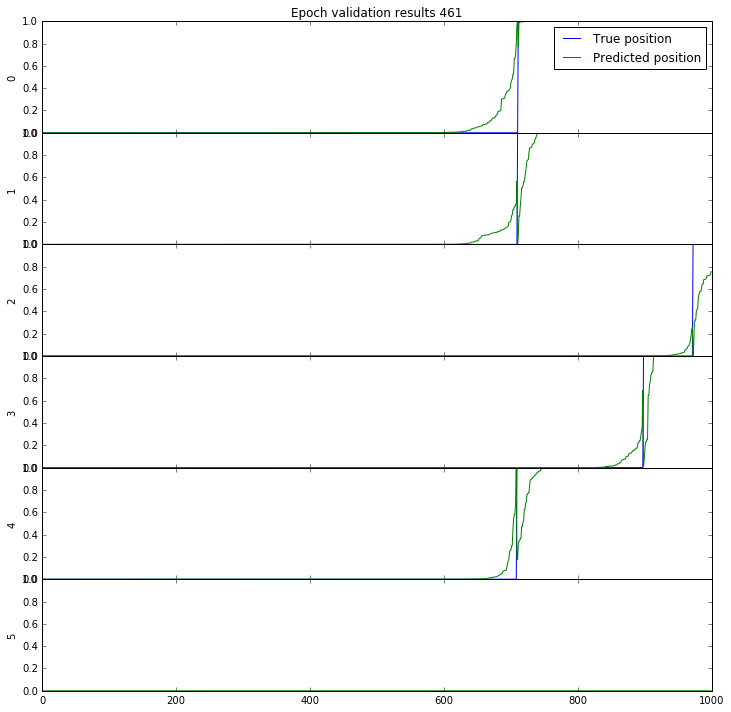

Wrote model to .\Models\models_461.h5
Epoch 462/462
161/161 [==============================] - 54s - loss: 0.2021 - categorical_accuracy: 0.9304 - val_loss: 0.1290 - val_categorical_accuracy: 0.9575
Wrote model to .\Models\models_462.h5
Epoch 463/463
161/161 [==============================] - 53s - loss: 0.1847 - categorical_accuracy: 0.9354 - val_loss: 0.0767 - val_categorical_accuracy: 0.9800
Wrote model to .\Models\models_463.h5
Epoch 464/464
161/161 [==============================] - 53s - loss: 0.1917 - categorical_accuracy: 0.9326 - val_loss: 0.1040 - val_categorical_accuracy: 0.9800
Wrote model to .\Models\models_464.h5
Epoch 465/465
161/161 [==============================] - 54s - loss: 0.2081 - categorical_accuracy: 0.9292 - val_loss: 0.0868 - val_categorical_accuracy: 0.9800
Wrote model to .\Models\models_465.h5
Epoch 466/466
161/161 [==============================] - 53s - loss: 0.1893 - categorical_accuracy: 0.9379 - val_loss: 0.0809 - val_categorical_accuracy: 0.9837
Wrote

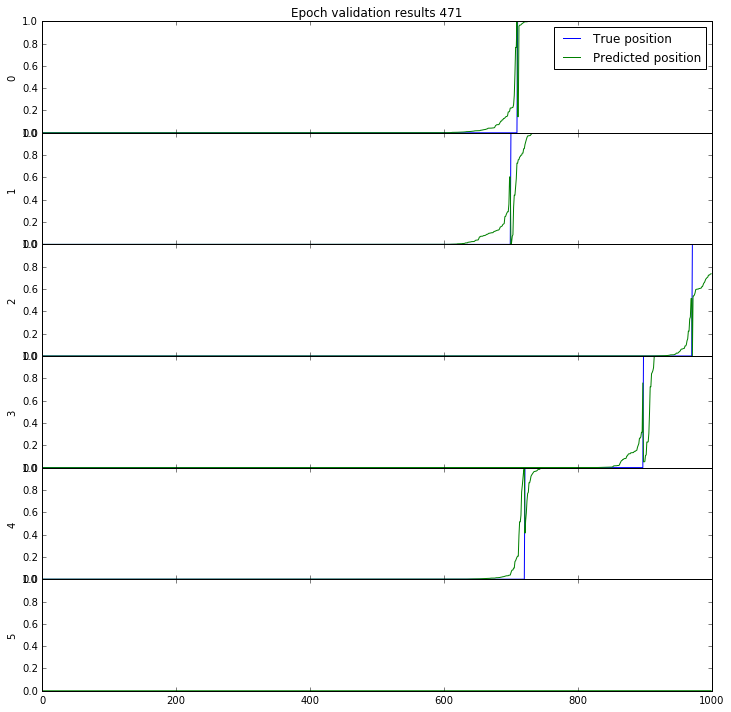

Wrote model to .\Models\models_471.h5
Epoch 472/472
161/161 [==============================] - 53s - loss: 0.2023 - categorical_accuracy: 0.9388 - val_loss: 0.0845 - val_categorical_accuracy: 0.9787
Wrote model to .\Models\models_472.h5
Epoch 473/473
161/161 [==============================] - 52s - loss: 0.1908 - categorical_accuracy: 0.9354 - val_loss: 0.0676 - val_categorical_accuracy: 0.9812
Wrote model to .\Models\models_473.h5
Epoch 474/474
161/161 [==============================] - 53s - loss: 0.1913 - categorical_accuracy: 0.9351 - val_loss: 0.0730 - val_categorical_accuracy: 0.9812
Wrote model to .\Models\models_474.h5
Epoch 475/475
161/161 [==============================] - 54s - loss: 0.2065 - categorical_accuracy: 0.9370 - val_loss: 0.0715 - val_categorical_accuracy: 0.9787
Wrote model to .\Models\models_475.h5
Epoch 476/476
161/161 [==============================] - 52s - loss: 0.1879 - categorical_accuracy: 0.9391 - val_loss: 0.0962 - val_categorical_accuracy: 0.9775
Wrote

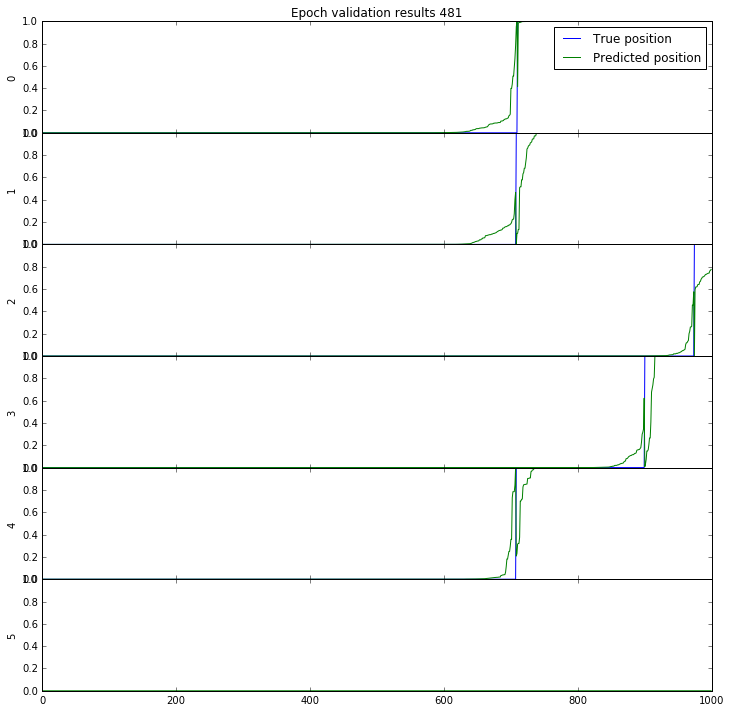

Wrote model to .\Models\models_481.h5
Epoch 482/482
161/161 [==============================] - 54s - loss: 0.2076 - categorical_accuracy: 0.9363 - val_loss: 0.0857 - val_categorical_accuracy: 0.9787
Wrote model to .\Models\models_482.h5
Epoch 483/483
161/161 [==============================] - 53s - loss: 0.1898 - categorical_accuracy: 0.9317 - val_loss: 0.0816 - val_categorical_accuracy: 0.9812
Wrote model to .\Models\models_483.h5
Epoch 484/484
161/161 [==============================] - 53s - loss: 0.1940 - categorical_accuracy: 0.9373 - val_loss: 0.0706 - val_categorical_accuracy: 0.9837
Wrote model to .\Models\models_484.h5
Epoch 485/485
161/161 [==============================] - 53s - loss: 0.1948 - categorical_accuracy: 0.9342 - val_loss: 0.1002 - val_categorical_accuracy: 0.9700
Wrote model to .\Models\models_485.h5
Epoch 486/486
161/161 [==============================] - 53s - loss: 0.1860 - categorical_accuracy: 0.9441 - val_loss: 0.0834 - val_categorical_accuracy: 0.9800
Wrote

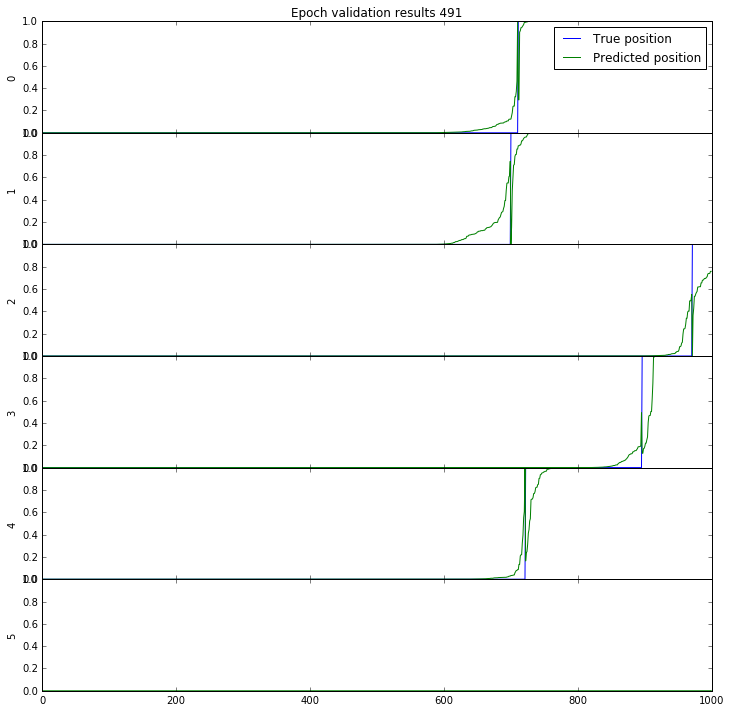

Wrote model to .\Models\models_491.h5
Epoch 492/492
161/161 [==============================] - 55s - loss: 0.1746 - categorical_accuracy: 0.9398 - val_loss: 0.1027 - val_categorical_accuracy: 0.9725
Wrote model to .\Models\models_492.h5
Epoch 493/493
161/161 [==============================] - 55s - loss: 0.1899 - categorical_accuracy: 0.9413 - val_loss: 0.0754 - val_categorical_accuracy: 0.9750
Wrote model to .\Models\models_493.h5
Epoch 494/494
161/161 [==============================] - 55s - loss: 0.2083 - categorical_accuracy: 0.9357 - val_loss: 0.0904 - val_categorical_accuracy: 0.9825


KeyboardInterrupt: 

In [16]:
# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Was ran on the above simple model, not pre-trained Inceptionv3 run.
epoch = 0
#batches_validation_per_epoch = 50
#batches_training_per_epoch = 400
batch_size = 20
batches_training_per_epoch = int(training.length / batch_size)
batches_validation_per_epoch = int(validation.length / batch_size)
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )
MODELS_FNAME = '.\\Models\\models_%i.h5'
os.makedirs("Models", exist_ok=True)

for i in range(500):
    model.fit_generator(
        TrainBatchGen(batch_size, training=training),
        batches_training_per_epoch,
        epochs=epoch+1,
        verbose=1,
        callbacks=None,
        class_weight=None,
        max_q_size=50,
        workers=50,
        validation_data=ValidationBatchGen(batch_size, validation),
        validation_steps = batches_validation_per_epoch,
        pickle_safe=False,
        initial_epoch=epoch)
    
    epoch += 1
    
    # Plot occasional validation data plot
    if i % 10 == 0:
        plot_validate(ValidationBatchGen(batch_size, validation), model, 1000, "Epoch validation results %i" % epoch, output_names)
    
    # Save the model
    model.save(MODELS_FNAME % epoch)
    print(("Wrote model to " + MODELS_FNAME )  % epoch)



In [ ]:
# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.000002),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Was ran on the above simple model, not pre-trained Inceptionv3 run.
epoch = 135
#batches_validation_per_epoch = 50
#batches_training_per_epoch = 400
batch_size = 20
batches_training_per_epoch = int(training.length / batch_size) / 5
batches_validation_per_epoch = int(validation.length / batch_size) / 5
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )
WEIGHTS_FNAME = '.\\Models\\weights_%i.hdf'
MODELS_FNAME = '.\\Models\\models_%i.h5'

for i in range(500):
    model.fit_generator(
        TrainBatchGen(batch_size, training=training),
        batches_training_per_epoch,
        epochs=epoch+1,
        verbose=1,
        callbacks=None,
        class_weight=None,
        max_q_size=50,
        workers=50,
        validation_data=ValidationBatchGen(batch_size, validation),
        validation_steps = batches_validation_per_epoch,
        pickle_safe=False,
        initial_epoch=epoch)
    
    epoch += 1
    
    # Plot occasional validation data plot
    if i % 10 == 0:
        plot_validate(ValidationBatchGen(batch_size, validation), model, 1000, "Epoch validation results %i" % epoch, output_names)
    
    # Save the model
    model.save_weights(WEIGHTS_FNAME % epoch)
    model.save(MODELS_FNAME % epoch)
    print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
